# Check Data Quality 

In [1518]:
pip install --upgrade matplotlib

     |████████████████████████████████| 12.5MB 7.1MB/s eta 0:00:01
  Found existing installation: matplotlib 3.1.1
    Uninstalling matplotlib-3.1.1:
      Successfully uninstalled matplotlib-3.1.1
Note: you may need to restart the kernel to use updated packages.


##  Imports

In [366]:
from scipy.io import wavfile
import tgt
import re
import collections
import os
import pandas as pd
import textgrids
import glob
import ipapy
from ipapy.ipachar import IPAVowel
import pickle
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 12})
import numpy as np
from pydub import AudioSegment,silence
import librosa
import librosa.display
import textgrids
import seaborn as sns
import scipy
import numba 
from numba import jit
import time
import speechpy
import math
import keras
from keras.layers import Dense, Dropout, Activation, Conv1D, GlobalMaxPooling1D, Embedding, MaxPooling1D, Flatten
from keras.models import Sequential, load_model
from keras.utils import to_categorical
from keras import backend as K
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import EarlyStopping,ModelCheckpoint
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
import itertools

### Import data 

In [10]:
with open("./After_filter/downsample_dictionary", "rb+") as f:
    downsample_dictionary = pickle.load(f)

In [11]:
with open("./After_filter/separated_after_filter_df", "rb+") as f:
    separated_df_list = pickle.load(f)

In [12]:
after_filter_df = pd.concat(separated_df_list)

# Displays using librosa
https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html
- lots of display options for waveforms here: https://stackoverflow.com/questions/18625085/how-to-plot-a-wav-file
- I could display waveform as a line graph (spline) using plotly and then have a sliding bar on the bottom that lets you scroll through the sound file https://plotly.com/python/line-charts/

In [13]:
# I'm downsampling the data here to 8000 sr/max of 4000 Hz measurements (https://stackoverflow.com/questions/30619740/downsampling-wav-audio-file)
librosa_audio, sr = librosa.load("./original_en_diapix_data/DP_ENF_02_ENF_06_EN_ENF_02_DP_ENF_02_ENF_06_EN_ENF_06.wav", duration = 30, sr = 8000)

### Waveform

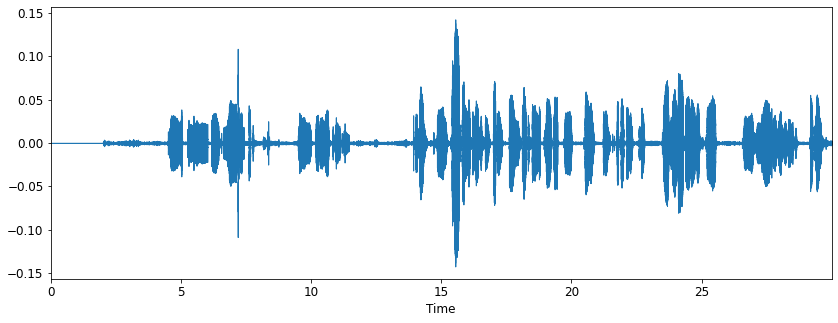

In [14]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(librosa_audio, sr=sr)
# plt.savefig('./Visualizations/Example_Waveform.png')

### Spectrogram

This chart shows how much useless info I'm getting from the signal (everything above 5,000 Hz). Will definitely need to downsample

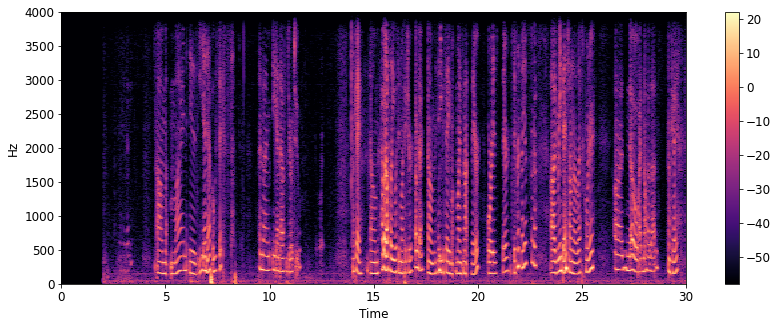

In [15]:
X = librosa.stft(librosa_audio)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
# plt.savefig('./Visualizations/Example_Spectrogram.png')

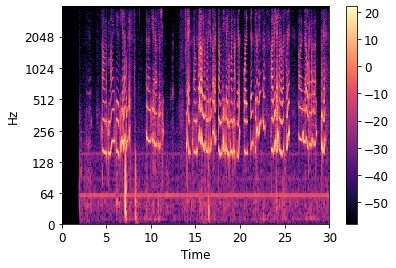

In [316]:
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()
# plt.savefig('./Visualizations/Example_MFCC_librosa.png', bbox_inches='tight')

### MFCC

(13, 469)


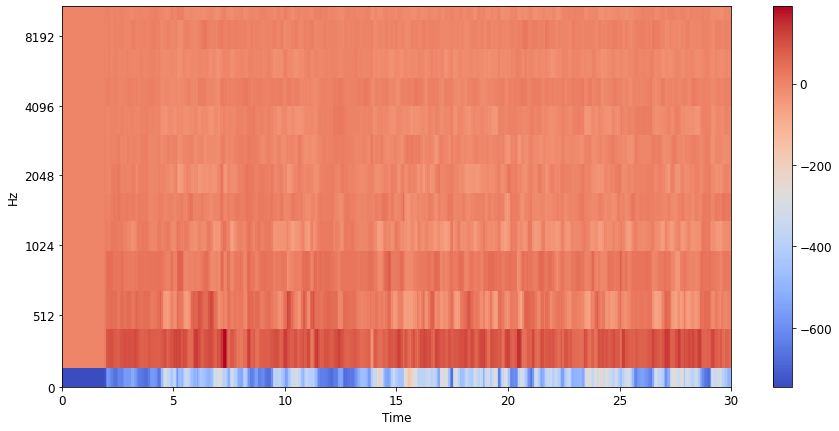

In [317]:
mfccs = librosa.feature.mfcc(librosa_audio, sr=sr, n_mfcc=13)
print(mfccs.shape)
(20, 97)
#Displaying  the MFCCs:
# plt.ylabel("Frequency bins (log transformed)")
plt.figure(figsize=(15, 7))
librosa.display.specshow(mfccs, sr=sr, x_axis='time', y_axis = 'mel')
plt.colorbar()
# plt.savefig('./Visualizations/Example_MFCC.png')

In [18]:
mfccs.shape

(15, 469)

## Waveform using plotly

In [19]:
data = downsample_dictionary['ENF_02']['original']

In [20]:
type(data)

numpy.ndarray

In [21]:
len(data)

4220833

In [22]:
data_df = pd.DataFrame(data)

data_df

fig = px.line(data_df.iloc[1000000:2000000], x=list(data_df.index), y = data_df[0])
fig.show()

## Making a display of a vowel heavy portion

In [23]:
# I need portions between frames 77416.0 - 79016
9.877 * 8000

79016.0

In [24]:
x = downsample_dictionary['ENF_02']['Filter_25_sigma_1.5'][1]

In [25]:
#first index that contains "AY" is 3874 and the one after is 4289
for item in x[3000:6000]:
    if item > 79016:
        print(x.index(item))
        break

4289


In [26]:
#getting the points into correct time
points_for_a = x[3874:4289]
len(points_for_a)

415

In [27]:
y = (np.array(points_for_a))
time_for_points_for_a = y * (1/8000)

In [28]:
y_axis = np.zeros(415,)
y_axis1 = y_axis - 3
# x1 = #9.677 
x2 = 9.877

Text(0.5, 1.0, "Example of the vowel in the word 'I' (9.67-9.87)")

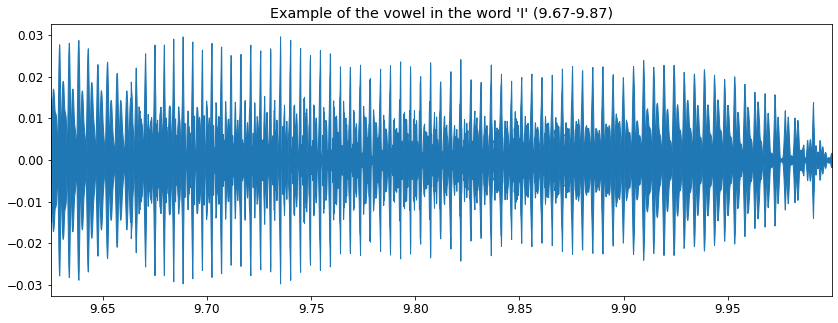

In [29]:
fig, ax = plt.subplots(figsize=(14, 5))
# plt.figure(figsize=(14, 5))
ax1 = librosa.display.waveplot(librosa_audio[77000:80000], sr=sr, ax=ax, x_axis = 'sec', offset = 9.625)
# ax.bar(time_for_points_for_a, height = 0.5)
# plt.fill_betweenx(0, x1, x2)
# sns.rugplot(time_for_points_for_a)
# fig, ax1 = plt.subplots()
# ax.plot(time_for_points_for_a, '|')
# plt.plot(y=0,x = 9.677)
ax.set_title("Example of the vowel in the word 'I' (9.67-9.87)")
# plt.savefig('./Visualizations/Example_Waveform_Vowel.png')

# Adding MFCC to the data

### What percentage of the data am I covering?  
9.8%

In [30]:
percent_in_low_sig = []
total_frames_to_check = 0
for x in downsample_dictionary.keys():
    total_len = len(downsample_dictionary[x]['original'])
    after_sig_len = after_filter_df[(after_filter_df['Speaker_key'] == x) & (after_filter_df['Filter'] == 'Filter_25_sigma_1.5')]['Number_of_Points']
    total_frames_to_check += after_sig_len
    percent_in_low_sig.append(int(after_sig_len) / total_len)

In [31]:
total_frames_to_check

0    5683512
Name: Number_of_Points, dtype: int64

In [32]:
# 9.8% of the data will be in the small sig
sum(percent_in_low_sig) / len(percent_in_low_sig)

0.09830831178911076

## Chunking the points into .025 sec intervals (if more than x frames)

In [33]:
# basically,the filter is in 1/8000 of a sec and the mfcc is 25/8000 of a second
## So I'm gonna convert the ham. filt data into chunks (if it has more than x frames marked)
small_test_data = downsample_dictionary['ENF_02']['Filter_200_sigma_2.5'][1]

In [34]:
len(downsample_dictionary['ENF_02']['Filter_200_sigma_2.5'][1])

66211

In [35]:
# she has about 801 vowels
66211 / 801
# so like 83 frames per vowel?

82.66042446941323

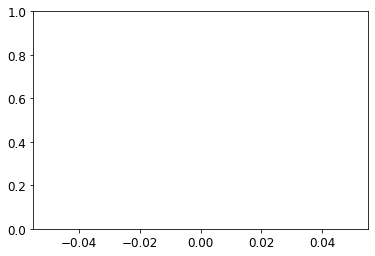

In [36]:
# looks like they are pretty well clustered already
sns.rugplot(small_test_data[0:50])

### Chunking my sound file into 0.025 chunks

In [37]:
time_02 = (len(downsample_dictionary['ENF_02']['Filter_200_sigma_2.5'][0])) / 8000

In [38]:
21105 / time_02

40.00158262598876

In [39]:
steps_for_02 = np.arange(0, time_02, .025)

In [40]:
len(steps_for_02)

21105

In [41]:
# find the intervals where there are more than x frames after ham filter
def check_filter_values(predictions, ranges):
    filled_ranges_list = []
    for x in range(0, len(ranges)-2):
        y = np.where((x+0.025 >= predictions) & (predictions >= x), 1, 0)
    #it's somehow faster to do this rather than np.sum(y)
        if np.sum(y) >= 5:
            filled_ranges_list.append(x)
    return filled_ranges_list

test_filt = check_filter_values(downsample_dictionary['ENF_02']['Filter_200_sigma_2.5'][1], steps_for_02)

test_filt

predictions = downsample_dictionary['ENF_02']['Filter_200_sigma_2.5'][1]
y = np.array([check_filter_values(x, steps_for_02) for x in predictions])

y

#### Testing on the small portion first

In [42]:
def check_filter_values_test(predictions, ranges):
    filled_ranges_list = []
    predictions = predictions / 8000
    for x in ranges:
        y = np.where((x+0.025 >= predictions) & (predictions >= x), 1, 0)
    #it's somehow faster to do this rather than np.sum(y)
        if np.sum(y) >= 2:
            filled_ranges_list.append(x)
    return filled_ranges_list

first_30_sec_2 = downsample_dictionary['ENF_02']['Filter_200_sigma_2.5'][1][0:4001]
steps_for_02_30 =  np.arange(0, 30, .025)

%%timeit
#time per 30 seconds of file 
y = check_filter_values_test(first_30_sec_2[0:10], steps_for_02_30)

In [43]:
y[0:5]

array([77428, 77429, 77430, 77431, 77432])

first_30_sec_2[0:30]

len(steps_for_02_30)

## Making an MFCC 

### Comparing running time of pyspeech and librosa

#### librosa

#%%timeit 
#over a 30 second frame
#over total frame, will take 200 ms or so
mfccs = librosa.feature.mfcc(librosa_audio, sr=sr, n_mfcc=15)

len(librosa_audio)

#### pyspeech

using first 240000 samples
pyspeech_samp = downsample_dictionary['ENF_02']['Filter_200_sigma_2.5'][0][0:240001]

pyspeech_mfcc = speechpy.feature.mfcc(signal = pyspeech_samp, sampling_frequency = 8000, frame_length = 0.025, 
                             frame_stride = 0.025)

def mfcc(signal, sampling_frequency, frame_length=0.020, frame_stride=0.01,num_cepstral =13,
       num_filters=40, fft_length=512, low_frequency=0, high_frequency=None, dc_elimination=True):
      """Compute MFCC features from an audio signal.
      :param signal: the audio signal from which to compute features. Should be an N x 1 array
      :param sampling_frequency: the sampling frequency of the signal we are working with.
      :param frame_length: the length of each frame in seconds. Default is 0.020s
      :param frame_stride: the step between successive frames in seconds. Default is 0.02s (means no overlap)
      :param num_filters: the number of filters in the filterbank, default 40.
      :param fft_length: number of FFT points. Default is 512.
      :param low_frequency: lowest band edge of mel filters. In Hz, default is 0.
      :param high_frequency: highest band edge of mel filters. In Hz, default is samplerate/2
      :param num_cepstral: Number of cepstral coefficients.
      :param dc_elimination: hIf the first dc component should be eliminated or not.
      :returns: A numpy array of size (num_frames x num_cepstral) containing mfcc features.
      """

### Using pyspeech 

In [44]:
# testing over whole file
pyspeech_samp1 = downsample_dictionary['ENF_02']['Filter_200_sigma_2.5'][0]

In [45]:
# %%timeit
pyspeech_mfcc = speechpy.feature.mfcc(signal = pyspeech_samp1, sampling_frequency = 8000, frame_length = 0.025, 
                             frame_stride = 0.025)

## combining mfcc with ham filter data 

### Example df

In [46]:
pyspeech_mfcc.shape

(21103, 13)

In [47]:
pyspeech_mfcc[0]

array([-0.60379279, -4.16716112,  0.0075956 , -0.95555573, -0.22759815,
       -0.54905464, -0.14696605, -0.2617947 ,  0.05138302, -0.09078346,
        0.08646743,  0.07548437,  0.22098299])

# Seeing how much data is in the corrected textgrid for speaker 2 

modified_tg is my ground truth and the downsample_dictionary is still my source for the hampel filter data

In [48]:
modified_tg = pd.read_csv("./corrected_textgrid/ENF_02_csv", index_col = 0)

In [49]:
modified_tg['Speaker'] = '02'

In [50]:
modified_tg.head(2)

,Phone_Text,Phone_xmin,Phone_xmax,Word_Text,Word_xmin,Word_xmax,Speaker
0,NaN,0.0,2.00000,NaN,0.0,2.000000,02
1,!SIL,2.0,9.49176,!SIL,2.0,9.457105,02


### How many frames would there be in each class? 

In [51]:
speech_sounds = list(modified_tg.Phone_Text.unique())

In [52]:
ortho_vowels = ['a', 'e', 'i', 'o', 'u']
vowels = [x for x in speech_sounds[1:] if x[0].lower() in ortho_vowels]

In [53]:
def add_vowel_col(df, vowels = vowels):
    vowel_col = []
    for item in df['Phone_Text']:
        if item in vowels:
            vowel_col.append(1)
        else:
            vowel_col.append(0)
    df['Vowel'] = vowel_col
    return df

In [54]:
modified_tg.Phone_Text.unique()

array([nan, '!SIL', 'y', 'N', 'DD', 'AY', 'M', 'IY', 'EH', 'F', 'Z', 'IH',
       'R', 'OW', 'T', 'UW', 'K', 'EY', 'AH', 'D', 'AA', 'TD', 'HH', 'AE',
       'V', 'DH', 'S', 'B', 'DX', 'AX', 'L', 'AXR', 'PD', 'Y', 'SH', 'TH',
       'NG', 'lg', 'UH', 'P', 'TS', 'AO', 'JH', 'KD', 'G', 'W', 'CH',
       'GD', 'IX', 'ER', 'SIL', 'AW', 'X', 'E', 'ls', 'br'], dtype=object)

#### Adding vowel col to modified_tg 

In [55]:
modified_tg = add_vowel_col(modified_tg, vowels = vowels)

In [56]:
modified_tg

,Phone_Text,Phone_xmin,Phone_xmax,Word_Text,Word_xmin,Word_xmax,Speaker,Vowel
0,NaN,0.000000,2.000000,NaN,0.000000,2.000000,02,0
1,!SIL,2.000000,9.491760,!SIL,2.000000,9.457105,02,0
2,y,9.491760,9.557000,!SIL,2.000000,9.457105,02,0
3,N,9.557000,9.647000,!SIL,2.000000,9.457105,02,0
4,DD,9.647000,9.677000,!SIL,2.000000,9.457105,02,0
...,...,...,...,...,...,...,...,...
1353,K,520.686125,520.726125,!SIL,518.455909,520.326117,02,0
1354,EY,520.726125,520.886125,!SIL,518.455909,520.326117,02,1
1355,lg,520.886125,521.407062,<LG>,520.886125,521.407062,02,0
1356,!SIL,521.407062,525.604172,!SIL,521.407062,525.604172,02,0


#### Add phone duration col

In [57]:
modified_tg['Phone_Duration'] = np.where((modified_tg['Phone_xmax'] - modified_tg['Phone_xmin']) > 0, 
                                     (modified_tg['Phone_xmax'] - modified_tg['Phone_xmin']),
                                     np.nan)

In [58]:
modified_tg.head(2)

,Phone_Text,Phone_xmin,Phone_xmax,Word_Text,Word_xmin,Word_xmax,Speaker,Vowel,Phone_Duration
0,NaN,0.0,2.00000,NaN,0.0,2.000000,02,0,2.00000
1,!SIL,2.0,9.49176,!SIL,2.0,9.457105,02,0,7.49176


#### Saving the modified_tg

modified_tg.to_csv("./corrected_textgrid/sp_2_df_w_features")

### Vowels make up 8% of total audio length

In [59]:
vowels_in_sec = modified_tg[modified_tg['Vowel'] == 1].Phone_Duration.sum()

In [60]:
modified_tg.Phone_Duration.sum()

527.6041723356011

In [61]:
vowels_in_sec / 527.6041723356011

0.0868843301983483

#### How many frames will that be?

In [62]:
samps_per_sec_25 = 1 / .025
vowels_in_sec * samps_per_sec_25

1833.6214049293053

In [63]:
samps_per_sec_10 = 1/ 0.01
vowels_in_sec * samps_per_sec_10

4584.053512323263

## Finding results of filter on corrected data

In [64]:
downsample_dictionary['ENF_02'].keys()

dict_keys(['original', 'Filter_25', 'Filter_200_sigma_3', 'Filter_200_sigma_2.5', 'Filter_25_sigma_1.5'])

#check for sigma = 3 and sigma = 1.5
corrected_sp2_sig3_results = check_all_values(modified_tg, speaker="02", hampel_filter = "Filter_25")

corrected_sp2_sig3_results

corrected_sp2_sig15_results = check_all_values(modified_tg, speaker="02", hampel_filter = "Filter_25_sigma_1.5")

corrected_sp2_sig15_results

## py speech mfcc data

In [65]:
len(downsample_dictionary['ENF_02']['Filter_25_sigma_1.5'][0])

4220833

In [66]:
signal = downsample_dictionary['ENF_02']['Filter_25_sigma_1.5'][0]
mfcc_2 = speechpy.feature.mfcc(signal = signal, sampling_frequency = 8000, frame_length = 0.015, 
                             frame_stride = 0.015)                 

In [67]:
# number of MFCC samples
len(mfcc_2)

35172

In [68]:
35172 * (15/1000)

527.5799999999999

I'm not sure what shape to feed into the neural network. For librosa the audio comes out (13, <larger_num>) whereas for speech py it comes out in the opposite shape. Alice Xue used librosa for hers. in the end i dont think there's a big difference between which of the two i use

Maybe I should use a smaller window and only check on samples that are ENTIRELY in a vowel window

### Getting Training and Test data  

In [69]:
mfcc_2[500]

array([10.81255957,  5.7552646 ,  5.13491405,  2.18335833,  2.07017293,
        1.81834554,  0.58493971,  0.045693  ,  0.81127398,  0.15346639,
        1.02417801,  1.06373032,  0.54250085])

In [70]:
modified_only_vow = modified_tg[modified_tg['Vowel'] == 1]

In [300]:
modified_only_vow.shape

(456, 9)

In [302]:
test_split_point / 50

422.04

In [306]:
modified_only_vow[modified_only_vow['Phone_xmin'] > 422.04]

,Phone_Text,Phone_xmin,Phone_xmax,Word_Text,Word_xmin,Word_xmax,Speaker,Vowel,Phone_Duration
1163,AX,422.254269,422.284250,and,422.254269,422.344250,02,1,0.029981
1167,EH,422.374250,422.534250,there's,422.344250,422.624250,02,1,0.160000
1171,AH,422.704250,422.794250,nothing,422.624250,422.964250,02,1,0.090000
1173,IX,422.854250,422.904250,nothing,422.624250,422.964250,02,1,0.050000
1175,IH,422.964250,423.004250,in,422.964250,423.084250,02,1,0.040000
...,...,...,...,...,...,...,...,...,...
1339,AO,513.709125,513.739125,pork,513.579125,513.859125,02,1,0.030000
1343,AA,513.969125,514.119125,chop,513.859125,514.329125,02,1,0.150000
1346,AE,514.539125,514.599125,that's,514.329125,514.649125,02,1,0.060000
1352,OW,520.391566,520.686125,!SIL,518.455909,520.326117,02,1,0.294559


In [307]:
456 - 63

393

In [308]:
1/8000

0.000125

#### Combine the chunks that are actually vowels with the chunks that my sampling window makes

my_ranges = np.arange(0, len(mfcc2)), (15/1000)
y = np.where((modified_only_vow['Phone_xmax'].values >= prediction) & (prediction >= modified_only_vow['Phone_xmin'].values))
y = np.where((sp_2_vcd['Phone_xmax'].values >= prediction) & (prediction >= sp_2_vcd['Phone_xmin'].values), 1, 0)
    #it's somehow faster to do this rather than np.sum(y)
    if np.sum(y) == 1:
        return 1
    else:
        return 0

In [72]:
def chunk_vowels_into_mfcc(df, chunk):
    chunk_time = chunk * (15/1000)
    y = np.where((df['Phone_xmax'].values >= chunk_time) & (chunk_time >= df['Phone_xmin'].values), chunk_time, 0)
    #it's somehow faster to do this rather than np.sum(y)
#     if np.sum(y) == 1:
#         return 1
#     else:
#         return 0
    return chunk_time

a = chunk_vowels_into_mfcc(modified_only_vow, my_ranges)

In [73]:
# my_ranges = np.arange(0, len(signal), (15/1000))
# chunked_vowel_times = [chunk_vowels_into_mfcc(modified_only_vow, x) for x in my_ranges]

In [74]:
my_ranges = np.arange(0, len(signal)/8000, (15/1000))
len(my_ranges)

35174

In [75]:
len(signal)/8000

527.604125

In [76]:
chunked_vowel_times = [chunk_vowels_into_mfcc(modified_only_vow, x) for x in my_ranges]

In [77]:
len(chunked_vowel_times)

35174

In [78]:
# chunked_vowel_times

In [79]:
my_ranges_1000 = np.arange(0, 1001, (15/1000))

In [80]:
modified_only_vow.head(2)

,Phone_Text,Phone_xmin,Phone_xmax,Word_Text,Word_xmin,Word_xmax,Speaker,Vowel,Phone_Duration
5,AY,9.677000,9.877,I'm,9.677,10.117,02,1,0.200000
8,IY,10.146561,10.297,I'm,9.677,10.117,02,1,0.150439


In [81]:
x = modified_only_vow['Phone_xmin'].values
y = modified_only_vow['Phone_xmax'].values
for item in [x,y]:
    print(item[0])

9.677
9.877


test_chunk = np.where(test > my_ranges_1000, my_ranges_1000, 0)

test_chunk[0:50]

#### Chunking my data into 20 ms

In [82]:
mfcc_20 = speechpy.feature.mfcc(signal = signal, sampling_frequency = 8000, frame_length = 0.02, 
                             frame_stride = 0.02)  

In [83]:
len(mfcc_20)

26379

In [84]:
# I want 67 to round up to 70
rounded_digit = 7
# in case it's less than 5, round to 5 (under count vowel)
if 0 <= rounded_digit < 5:
    new_digit = 5
elif 5 <= rounded_digit < 10:
    new_digit = 0

##### Rounded tens place digit approach

def chunk_orig_interval_edge(df):
    start = df['Phone_xmin'].values
    end = df['Phone_xmax'].values
    new_start = []
    new_end = []
    for item in start:
        rounded_dig = round(item % 0.1, 5) * 100
        if 0 <= rounded_dig < 5:
            new_digit = 5
        elif 5 <= rounded_dig < 10:
            new_digit = 0
        the_time_times_10 = math.floor((item * 10))
        item_times_100 = (the_time_times_10 * 10) + new_digit
        actual_time = item_times_100 / 100
        new_start.append(actual_time)
    for item in end:
        rounded_dig = round(item % 0.1, 5) * 100
        if 0 <= rounded_dig < 5:
            new_digit = 0
        elif 5 <= rounded_dig < 10:
            new_digit = 5
        the_time_times_10 = math.floor((item * 10))
        item_times_100 = (the_time_times_10 * 10) + new_digit
        actual_time = item_times_100 / 100
        new_end.append(actual_time)
    return new_start, new_end

In [85]:
start1, end1 = chunk_orig_interval_edge(modified_only_vow)

NameError: name 'chunk_orig_interval_edge' is not defined

len(start1) == len(end1)

### Vowel indices in scale of 20 ms frame window

start_array = (np.array(start1)) * 20
end_array = (np.array(end1)) * 20

#make sure to INCLUDE the last frame
print(end1[0])
print(y[0])

vowel_frame_range_counts = (end_array + 1) - start_array

np.sum(vowel_frame_range_counts)

#1361 frames are vowels
1361 / len(mfcc_20)

len(mfcc_20)

527 / 26379

### chunking into 20 ms without sliding window -- before i did .05

In [87]:
# rounding each value to .02 (in this way MOST of the frame is a vowel)
start2_1 = modified_only_vow['Phone_xmin'].values
end2_1 = modified_only_vow['Phone_xmax'].values

In [88]:
def make_into_02_chunk(x):
    return (np.round(x * 50)) / 50

In [89]:
start2 = [make_into_02_chunk(x) for x in start2_1]

In [90]:
end2 = [make_into_02_chunk(x) for x in end2_1]

In [91]:
len(end2)

456

In [92]:
# we want the frame to end at end2, so we won't add to it
vowel_frame_range_counts2 = ((np.array(end2)) - (np.array(start2))) * 50

In [93]:
len(vowel_frame_range_counts2)

456

In [94]:
np.sum(vowel_frame_range_counts2)

2300.000000000008

In [95]:
# now thati calculated it correctly, the percent of the file that are vowels in the file is correct
(np.sum(vowel_frame_range_counts2)) / len(mfcc_20)

0.08719056825505167

# Adding new data (speaker 6)

In [96]:
sp6 = pd.read_csv("./corrected_textgrid/sp_6_df")

In [97]:
sp6.head()

,Unnamed: 0,Phone_Text,Phone_xmin,Phone_xmax,Word_Text,Word_xmin,Word_xmax,Vowel,Speech_Sound,Phone_Duration
0,0,NaN,0.000000,2.000000,NaN,0.000000,2.000000,0,0,2.000000
1,1,!SIL,2.000000,4.589832,!SIL,2.000000,4.361218,0,0,2.589832
2,2,AH,4.589832,4.831125,!SIL,2.000000,4.361218,1,1,0.241293
3,3,M,4.831125,5.141125,!SIL,2.000000,4.361218,0,1,0.310000
4,4,M,5.141125,5.481125,mine,5.141125,6.111125,0,1,0.340000


### Getting vowel intervals

In [98]:
sp6_only_vowels = sp6[sp6['Vowel'] == 1]

In [99]:
start6values = sp6_only_vowels['Phone_xmin'].values
end6values = sp6_only_vowels['Phone_xmax'].values

In [100]:
start6 = [make_into_02_chunk(x) for x in start6values]
end6 =  [make_into_02_chunk(x) for x in end6values]

In [101]:
len(end6)

730

In [102]:
vowel_frame_range_counts6 = ((np.array(end6)) - (np.array(start6))) * 50

In [103]:
len(vowel_frame_range_counts6)

730

In [104]:
np.sum(vowel_frame_range_counts6)

4202.99999999996

### Getting audio

In [105]:
signal_6 = downsample_dictionary['ENF_06']['Filter_25_sigma_1.5'][0]

In [106]:
mfcc_6 = speechpy.feature.mfcc(signal = signal_6, sampling_frequency = 8000, frame_length = 0.02, 
                             frame_stride = 0.02)  

In [107]:
np.sum(vowel_frame_range_counts6) / len(mfcc_6)

0.15933128625042495

# CNN -- No sliding window
- https://stackoverflow.com/questions/40355288/one-dimensional-data-with-cnn
"A cnn only has sense 1 dim aray if the features compose a sequence, for example a time serie." - couldn't have said it better myself 
- 1D CNN https://towardsdatascience.com/understanding-1d-and-3d-convolution-neural-network-keras-9d8f76e29610
- Video https://www.digikey.com/en/maker/projects/tensorflow-lite-tutorial-part-2-speech-recognition-model-training/d8d04a2b60a442cf8c3fa5c0dd2a292b

## Test/validate/Train Split

#### Combining the start and end list

In [108]:
end2[0] * 50

494.00000000000006

In [109]:
# multiply each element by 50 
beg_frame = np.array(start2) * 50
end_frame = np.array(end2) * 50

In [110]:
len(beg_frame)

456

In [111]:
vowel_frames_zip = list(zip(beg_frame, end_frame))

In [112]:
vowel_frames_zip[1]

(507.0, 515.0)

In [113]:
vowel_indices = []
for x in vowel_frames_zip:
    for y in np.arange(x[0], x[1]):
        vowel_indices.append(int(y))

In [114]:
len(vowel_indices)

2326

#### Making labels

In [115]:
# these are the frame numbers of the mfcc's
len(mfcc_20)

26379

In [116]:
labels_20 = np.zeros(len(mfcc_20))

In [117]:
for x in vowel_indices:
    labels_20[x] = 1

In [118]:
np.sum(labels_20)

2326.0

In [119]:
labels_20[507:530]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       1., 1., 1., 1., 1., 1.])

#### The actual (banana) split
- tuning the split point https://stackoverflow.com/questions/13610074/is-there-a-rule-of-thumb-for-how-to-divide-a-dataset-into-training-and-validatio

In [120]:
# splitting by time in df
train_split_point = int(len(mfcc_20) * .65) # 65 percent will be training
test_split_point = int(len(mfcc_20) * .65) + int(len(mfcc_20) * .15) # will be 20 percent
eighty_20_split_point = len(mfcc_20) * 0.8

In [121]:
test_split_point 

21102

In [122]:
x_train20 = mfcc_20[train_split_point:]
y_train20 = labels_20[train_split_point:]

In [123]:
x_valid20 = mfcc_20[train_split_point:test_split_point]
y_valid20 = labels_20[train_split_point:test_split_point]

In [124]:
x_test20 = mfcc_20[test_split_point:]
y_test20 = labels_20[test_split_point:]

In [ ]:
len(x_test20) == len(y_test20)

In [ ]:
print(f"length of train {len(x_train20)}, validation {len(x_valid20)}, test {len(x_test20)}")

In [ ]:
print(f"length of train {len(y_train20)}, validation {len(y_valid20)}, test {len(y_test20)}")

#### Saving the split data

! mkdir test_train_split_20_sp2

train
with open("./test_train_split_20_sp2/xtrain", "wb+") as f:
    pickle.dump(x_train20, f)
with open("./test_train_split_20_sp2/ytrain", "wb+") as f:
    pickle.dump(y_train20, f)

validate
with open("./test_train_split_20_sp2/xvalid", "wb+") as f:
    pickle.dump(x_valid20, f)
with open("./test_train_split_20_sp2/yvalid", "wb+") as f:
    pickle.dump(y_valid20, f)

test
with open("./test_train_split_20_sp2/xtest", "wb+") as f:
    pickle.dump(x_test20, f)
with open("./test_train_split_20_sp2/ytest", "wb+") as f:
    pickle.dump(y_test20, f)

## Vanilla neural net

### Changing all of the y examples to be [0, 1] for each example, not just 1

#### ytest

In [145]:
ytest_opposite = np.where(y_test20 > 0., 0., 1.)

In [146]:
ytest_comb = list(zip(y_test20, ytest_opposite))

In [147]:
ytest_comb_list = []
for tup in ytest_comb:
    ytest_comb_list.append(list(tup))

In [148]:
# if it is a vowel, it has a 1 in the first position, if not, it has a 0 in the first position
ytest_array = np.array(ytest_comb_list)

In [149]:
ytest_array.shape

(5277, 2)

In [150]:
y_test20.shape

(5277,)

In [151]:
len(ytest_opposite)

5277

#### validation

In [152]:
yvalid_opposite = np.where(y_valid20 > 0, 0., 1.)

In [153]:
yvalid_comb = list(zip(y_valid20, yvalid_opposite))

In [154]:
yvalid_comb_list = []
for tup in yvalid_comb:
    yvalid_comb_list.append(list(tup))

In [155]:
# if it is a vowel, it has a 1 in the first position, if not, it has a 0 in the first position
yvalid_array = np.array(yvalid_comb_list)

In [156]:
yvalid_array.shape

(3956, 2)

In [157]:
x_test20.shape

(5277, 13)

In [158]:
y_test20.shape

(5277,)

#### train

In [159]:
ytrain_opposite = np.where(y_train20 > 0, 0., 1.)

ytrain_comb = list(zip(y_train20, ytrain_opposite))

ytrain_comb_list = []
for tup in ytrain_comb:
    ytrain_comb_list.append(list(tup))

# if it is a vowel, it has a 1 in the first position, if not, it has a 0 in the first position
ytrain_array = np.array(ytrain_comb_list)

ytrain_array.shape

(9233, 2)

#### Checking i have the right sizes

In [160]:
print('Test label shape:', np.shape(ytest_array))
print('Valid label shape:', np.shape(yvalid_array))
print('Train label shape:', np.shape(ytrain_array))
print('Test shape:', np.shape(x_test20))
print('Valid shape:', np.shape(x_valid20))
print('Train shape:', np.shape(x_train20))

Test label shape: (5277, 2)
Valid label shape: (3956, 2)
Train label shape: (9233, 2)
Test shape: (5277, 13)
Valid shape: (3956, 13)
Train shape: (9233, 13)


In [469]:
# y_test20[0:50]

In [471]:
# ytest_array[0:50]

In [371]:
np.sum(y_train20)

847.0

In [374]:
np.sum(y_valid20)

509.0

## Adding recall, precision, and f1 scores
https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

In [198]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Running first model (more layers, 1 dropout)

In [215]:
# Initialize a sequential model
model = Sequential()
# Two layers with relu activation 8 layers
model.add(Dense(50, activation='relu', input_shape=(13,)))
model.add(Dense(25, activation='relu'))
model.add(Dense(25, activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(25, activation='relu'))
model.add(Dense(25, activation='tanh'))
model.add(Dense(25, activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(25, activation='tanh'))
model.add(Dense(25, activation='relu'))
# One layer with sigmoid activation 
model.add(Dense(1, activation='sigmoid'))

In [231]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', recall_m, precision_m, f1_m]) 

In [232]:
es = EarlyStopping(monitor = 'val_acc', mode = 'max', patience = 5, min_delta = 1)
mcb = ModelCheckpoint('history', monitor= 'val_acc', mode = 'max', verbose = 1, save_best_only=True)

In [233]:
# Train the model 
history = model.fit(x_train20, y_train20,
                    batch_size=64,
                    epochs=75,
                    validation_data=(x_valid20, y_valid20), 
                   callbacks = [es, mcb])
                    #class_weight = {0: (len(y_train20) - np.sum(y_train20)) / len(y_train20),
                     #                   1: np.sum(y_train20) / len(y_train20)})

Train on 9233 samples, validate on 3956 samples
Epoch 1/75
9233/9233 [==============================] - 1s 81us/step - loss: 0.1934 - acc: 0.9106 - recall_m: 0.1093 - precision_m: 0.2503 - f1_m: 0.1389 - val_loss: 0.2195 - val_acc: 0.8961 - val_recall_m: 0.2859 - val_precision_m: 0.3401 - val_f1_m: 0.2851

Epoch 00001: val_acc improved from -inf to 0.89611, saving model to history
Epoch 2/75
9233/9233 [==============================] - 0s 31us/step - loss: 0.1841 - acc: 0.9129 - recall_m: 0.2641 - precision_m: 0.4622 - f1_m: 0.2994 - val_loss: 0.2095 - val_acc: 0.9027 - val_recall_m: 0.3445 - val_precision_m: 0.3339 - val_f1_m: 0.3132

Epoch 00002: val_acc improved from 0.89611 to 0.90268, saving model to history
Epoch 3/75
9233/9233 [==============================] - 0s 32us/step - loss: 0.1776 - acc: 0.9183 - recall_m: 0.3923 - precision_m: 0.5808 - f1_m: 0.4339 - val_loss: 0.2020 - val_acc: 0.9115 - val_recall_m: 0.3287 - val_precision_m: 0.3450 - val_f1_m: 0.3231

Epoch 00003: val_

In [234]:
#history
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'val_recall_m', 'val_precision_m', 'val_f1_m', 'loss', 'acc', 'recall_m', 'precision_m', 'f1_m'])

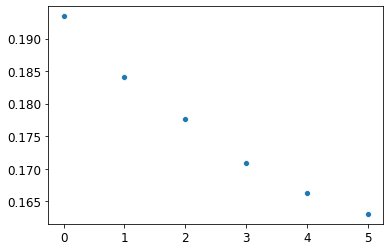

In [235]:
# Plot the loss vs the number of epoch
sns.scatterplot(x = range(len(history_dict['loss'])), y=history_dict['loss'])

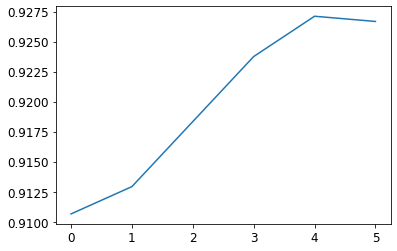

In [236]:
# Plot the training accuracy vs the number of epochs
sns.lineplot(x = range(len(history_dict['acc'])), y=history_dict['acc'])

In [243]:
#comparing the value given here to choosing randomly
# y_test20.sum() / len(y_test20)

In [238]:
# Output (probability) predictions for the test set 
y_hat_test = model.predict(x_test20)

In [239]:
# Print the loss and accuracy for the training set 
results_train = model.evaluate(x_train20, y_train20)
results_train

9233/9233 [==============================] - 0s 21us/step


[0.15434407148394522,
 0.9337160186288314,
 0.17582431402984192,
 0.1832897732062367,
 0.1713971507571235]

In [240]:
# Print the loss and accuracy for the test set (it prints the evaluation metric values given to it)
results_test = model.evaluate(x_test20, y_test20)
results_test

5277/5277 [==============================] - 0s 21us/step


[0.12726402744466941,
 0.9475080538184575,
 0.14507338918021215,
 0.14764457248660998,
 0.13450314218355938]

### Evaluating the model with hampel filter

In [241]:
ynew = model.predict_classes(x_test20)

In [242]:
ynew.sum()

407

over_50 = np.where(y_hat_test > 0.15, 1, 0)

over_50.sum()

y_test20.sum()

over_50.sum() / y_test20.sum()

see how many of ynew and y_test20 labels overlap
y_mismatch = np.where(y_test20 != ynew, 1, 0)

np.sum(y_mismatch)

y_agreement = np.where(y_test20 == ynew, 1, 0)

np.sum(y_agreement)

both_y_are_1 = np.where((y_test20 == 1) & (ynew == 1), 1, 0)

np.sum(both_y_are_1)

both_y_are_0 = np.where((y_test20 == 0) & (ynew == 0), 1, 0)

np.sum(both_y_are_0)

ynew[0:50]

In [244]:
ynew.min()

0

In [245]:
ynew.max()

1

### Evaluating using sklearn metrics

In [246]:
ynew = model.predict_classes(x_test20)
print(classification_report(y_test20, ynew, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97      4939
         1.0       0.57      0.69      0.63       338

    accuracy                           0.95      5277
   macro avg       0.78      0.83      0.80      5277
weighted avg       0.95      0.95      0.95      5277



In [247]:
best_neuralnet_predictions = ynew

## Vanilla neural net with more layers

In [323]:
# Initialize a sequential model
model_morelayers = Sequential()

# Two layers with relu activation
model_morelayers.add(Dense(50, activation='relu', input_shape=(13,)))
model_morelayers.add(Dense(25, activation='relu'))
model_morelayers.add(Dense(50, activation='relu', input_shape=(13,)))
model_morelayers.add(Dense(25, activation='relu'))

# One layer with softmax activation 
model_morelayers.add(Dense(2, activation='sigmoid'))

In [324]:
# Compile the model
model_morelayers.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy']) 

In [829]:
# Train the model 
history_morelayers = model_morelayers.fit(x_train20, ytrain_array,
                    batch_size=256,
                    epochs=120,
                    validation_data=(x_valid20, yvalid_array))

Train on 9233 samples, validate on 3956 samples
Epoch 1/120
9233/9233 [==============================] - 0s 29us/step - loss: 0.4274 - acc: 0.8814 - val_loss: 0.3756 - val_acc: 0.8713
Epoch 2/120
9233/9233 [==============================] - 0s 6us/step - loss: 0.2975 - acc: 0.9083 - val_loss: 0.3330 - val_acc: 0.8713
Epoch 3/120
9233/9233 [==============================] - 0s 6us/step - loss: 0.2716 - acc: 0.9083 - val_loss: 0.3083 - val_acc: 0.8713
Epoch 4/120
9233/9233 [==============================] - 0s 6us/step - loss: 0.2534 - acc: 0.9083 - val_loss: 0.2891 - val_acc: 0.8713
Epoch 5/120
9233/9233 [==============================] - 0s 6us/step - loss: 0.2409 - acc: 0.9083 - val_loss: 0.2721 - val_acc: 0.8713
Epoch 6/120
9233/9233 [==============================] - 0s 6us/step - loss: 0.2322 - acc: 0.9082 - val_loss: 0.2715 - val_acc: 0.8713
Epoch 7/120
9233/9233 [==============================] - 0s 6us/step - loss: 0.2261 - acc: 0.9083 - val_loss: 0.2563 - val_acc: 0.8711
Epoch 

Epoch 61/120
9233/9233 [==============================] - 0s 7us/step - loss: 0.1898 - acc: 0.9083 - val_loss: 0.2358 - val_acc: 0.8713
Epoch 62/120
9233/9233 [==============================] - 0s 6us/step - loss: 0.1895 - acc: 0.9083 - val_loss: 0.2336 - val_acc: 0.8713
Epoch 63/120
9233/9233 [==============================] - 0s 7us/step - loss: 0.1891 - acc: 0.9083 - val_loss: 0.2341 - val_acc: 0.8713
Epoch 64/120
9233/9233 [==============================] - 0s 7us/step - loss: 0.1889 - acc: 0.9083 - val_loss: 0.2325 - val_acc: 0.8713
Epoch 65/120
9233/9233 [==============================] - 0s 7us/step - loss: 0.1887 - acc: 0.9083 - val_loss: 0.2383 - val_acc: 0.8713
Epoch 66/120
9233/9233 [==============================] - 0s 7us/step - loss: 0.1883 - acc: 0.9083 - val_loss: 0.2318 - val_acc: 0.8713
Epoch 67/120
9233/9233 [==============================] - 0s 7us/step - loss: 0.1882 - acc: 0.9083 - val_loss: 0.2316 - val_acc: 0.8713
Epoch 68/120
9233/9233 [========================

In [830]:
#history
history_morelayers_dict = history_morelayers.history
history_morelayers_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

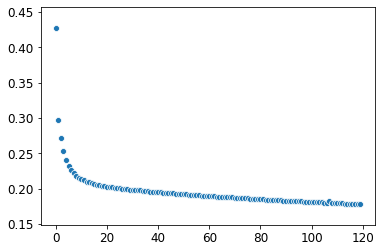

In [832]:
sns.scatterplot(x = range(len(history_morelayers_dict['loss'])), y=history_morelayers_dict['loss'])

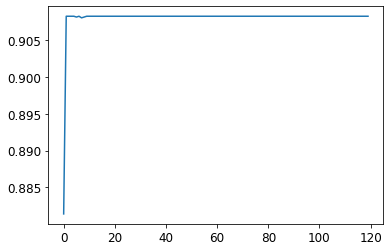

In [833]:
sns.lineplot(x = range(len(history_morelayers_dict['acc'])), y=history_morelayers_dict['acc'])

In [834]:
# Output (probability) predictions for the test set 
y_hat_test_morelayers = model_morelayers.predict(x_test20)

In [835]:
# Print the loss and accuracy for the training set 
results_trainmorelayers = model_morelayers.evaluate(x_train20, ytrain_array)
results_trainmorelayers

9233/9233 [==============================] - 0s 15us/step


[0.17776056981226818, 0.9082638362395754]

In [836]:
# Print the loss and accuracy for the test set (it prints the evaluation metric values given to it)
results_testmorelayers = model_morelayers.evaluate(x_test20, ytest_array)
results_testmorelayers

5277/5277 [==============================] - 0s 16us/step


[0.14322541848951745, 0.9359484555618722]

In [837]:
ynew_morelayers = model_morelayers.predict_classes(x_test20)

In [842]:
y_test20.sum() 

338.0

In [848]:
len(ynew_morelayers)

5277

In [846]:
ynew_morelayers.sum()

5277

### Evaluating using sklearn

In [325]:
y_pred = model_morelayers.predict(x_test20, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test20, y_pred_bool))

5277/5277 [==============================] - 0s 22us/step
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97      4938
         1.0       0.00      0.00      0.00       339

    accuracy                           0.94      5277
   macro avg       0.47      0.50      0.48      5277
weighted avg       0.88      0.94      0.90      5277



/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Vanilla neural net more epochs

In [326]:
# Initialize a sequential model
modelhiepoc = Sequential()

# Two layers with relu activation
modelhiepoc.add(Dense(50, activation='relu', input_shape=(13,)))
modelhiepoc.add(Dense(25, activation='relu'))

# One layer with softmax activation 
modelhiepoc.add(Dense(2, activation='sigmoid'))

In [327]:
# Compile the model
modelhiepoc.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy']) 

In [853]:
# Train the model 
historyhiepoch = modelhiepoc.fit(x_train20, ytrain_array,
                    batch_size=256,
                    epochs=250,
                    validation_data=(x_valid20, yvalid_array))

Train on 9233 samples, validate on 3956 samples
Epoch 1/250
9233/9233 [==============================] - 0s 29us/step - loss: 0.4053 - acc: 0.8892 - val_loss: 0.4081 - val_acc: 0.8713
Epoch 2/250
9233/9233 [==============================] - 0s 5us/step - loss: 0.3000 - acc: 0.9083 - val_loss: 0.3418 - val_acc: 0.8713
Epoch 3/250
9233/9233 [==============================] - 0s 6us/step - loss: 0.2661 - acc: 0.9083 - val_loss: 0.2999 - val_acc: 0.8713
Epoch 4/250
9233/9233 [==============================] - 0s 5us/step - loss: 0.2472 - acc: 0.9083 - val_loss: 0.2856 - val_acc: 0.8713
Epoch 5/250
9233/9233 [==============================] - 0s 5us/step - loss: 0.2363 - acc: 0.9083 - val_loss: 0.2792 - val_acc: 0.8713
Epoch 6/250
9233/9233 [==============================] - 0s 5us/step - loss: 0.2289 - acc: 0.9083 - val_loss: 0.2648 - val_acc: 0.8713
Epoch 7/250
9233/9233 [==============================] - 0s 5us/step - loss: 0.2235 - acc: 0.9082 - val_loss: 0.2638 - val_acc: 0.8713
Epoch 

Epoch 61/250
9233/9233 [==============================] - 0s 5us/step - loss: 0.1931 - acc: 0.9083 - val_loss: 0.2313 - val_acc: 0.8713
Epoch 62/250
9233/9233 [==============================] - 0s 5us/step - loss: 0.1930 - acc: 0.9083 - val_loss: 0.2401 - val_acc: 0.8713
Epoch 63/250
9233/9233 [==============================] - 0s 5us/step - loss: 0.1930 - acc: 0.9083 - val_loss: 0.2353 - val_acc: 0.8713
Epoch 64/250
9233/9233 [==============================] - 0s 6us/step - loss: 0.1927 - acc: 0.9083 - val_loss: 0.2308 - val_acc: 0.8713
Epoch 65/250
9233/9233 [==============================] - 0s 5us/step - loss: 0.1926 - acc: 0.9083 - val_loss: 0.2401 - val_acc: 0.8713
Epoch 66/250
9233/9233 [==============================] - 0s 5us/step - loss: 0.1925 - acc: 0.9083 - val_loss: 0.2339 - val_acc: 0.8713
Epoch 67/250
9233/9233 [==============================] - 0s 5us/step - loss: 0.1923 - acc: 0.9083 - val_loss: 0.2367 - val_acc: 0.8713
Epoch 68/250
9233/9233 [========================

9233/9233 [==============================] - 0s 5us/step - loss: 0.1856 - acc: 0.9083 - val_loss: 0.2286 - val_acc: 0.8713
Epoch 122/250
9233/9233 [==============================] - 0s 5us/step - loss: 0.1855 - acc: 0.9083 - val_loss: 0.2271 - val_acc: 0.8713
Epoch 123/250
9233/9233 [==============================] - 0s 5us/step - loss: 0.1854 - acc: 0.9083 - val_loss: 0.2240 - val_acc: 0.8713
Epoch 124/250
9233/9233 [==============================] - 0s 5us/step - loss: 0.1856 - acc: 0.9083 - val_loss: 0.2280 - val_acc: 0.8713
Epoch 125/250
9233/9233 [==============================] - 0s 5us/step - loss: 0.1850 - acc: 0.9083 - val_loss: 0.2258 - val_acc: 0.8713
Epoch 126/250
9233/9233 [==============================] - 0s 5us/step - loss: 0.1848 - acc: 0.9083 - val_loss: 0.2260 - val_acc: 0.8713
Epoch 127/250
9233/9233 [==============================] - 0s 5us/step - loss: 0.1849 - acc: 0.9083 - val_loss: 0.2293 - val_acc: 0.8713
Epoch 128/250
9233/9233 [==============================

Epoch 181/250
9233/9233 [==============================] - 0s 5us/step - loss: 0.1801 - acc: 0.9083 - val_loss: 0.2307 - val_acc: 0.8713
Epoch 182/250
9233/9233 [==============================] - 0s 5us/step - loss: 0.1800 - acc: 0.9083 - val_loss: 0.2279 - val_acc: 0.8713
Epoch 183/250
9233/9233 [==============================] - 0s 6us/step - loss: 0.1799 - acc: 0.9083 - val_loss: 0.2276 - val_acc: 0.8713
Epoch 184/250
9233/9233 [==============================] - 0s 6us/step - loss: 0.1798 - acc: 0.9083 - val_loss: 0.2243 - val_acc: 0.8713
Epoch 185/250
9233/9233 [==============================] - 0s 6us/step - loss: 0.1797 - acc: 0.9083 - val_loss: 0.2273 - val_acc: 0.8713
Epoch 186/250
9233/9233 [==============================] - 0s 6us/step - loss: 0.1796 - acc: 0.9083 - val_loss: 0.2251 - val_acc: 0.8713
Epoch 187/250
9233/9233 [==============================] - 0s 5us/step - loss: 0.1796 - acc: 0.9083 - val_loss: 0.2278 - val_acc: 0.8713
Epoch 188/250
9233/9233 [================

Epoch 241/250
9233/9233 [==============================] - 0s 5us/step - loss: 0.1754 - acc: 0.9083 - val_loss: 0.2181 - val_acc: 0.8713
Epoch 242/250
9233/9233 [==============================] - 0s 5us/step - loss: 0.1754 - acc: 0.9083 - val_loss: 0.2150 - val_acc: 0.8713
Epoch 243/250
9233/9233 [==============================] - 0s 5us/step - loss: 0.1754 - acc: 0.9083 - val_loss: 0.2198 - val_acc: 0.8713
Epoch 244/250
9233/9233 [==============================] - 0s 5us/step - loss: 0.1751 - acc: 0.9083 - val_loss: 0.2239 - val_acc: 0.8713
Epoch 245/250
9233/9233 [==============================] - 0s 5us/step - loss: 0.1751 - acc: 0.9083 - val_loss: 0.2165 - val_acc: 0.8713
Epoch 246/250
9233/9233 [==============================] - 0s 5us/step - loss: 0.1757 - acc: 0.9083 - val_loss: 0.2170 - val_acc: 0.8713
Epoch 247/250
9233/9233 [==============================] - 0s 5us/step - loss: 0.1750 - acc: 0.9083 - val_loss: 0.2215 - val_acc: 0.8713
Epoch 248/250
9233/9233 [================

In [854]:
#history
historyhiepoch_dict = historyhiepoch.history
historyhiepoch_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

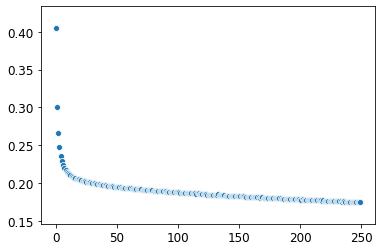

In [855]:
# Plot the loss vs the number of epoch
sns.scatterplot(x = range(len(historyhiepoch_dict['loss'])), y=historyhiepoch_dict['loss'])

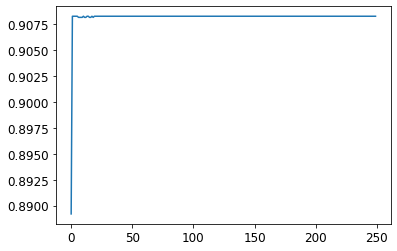

In [856]:
# Plot the training accuracy vs the number of epochs
sns.lineplot(x = range(len(historyhiepoch_dict['acc'])), y=historyhiepoch_dict['acc'])

In [857]:
#comparing the value given here to choosing randomly
y_test20.sum() / len(y_test20)

0.06405154443812773

In [859]:
# Output (probability) predictions for the test set 
y_hat_testhiepoch = modelhiepoc.predict(x_test20)

In [860]:
# Print the loss and accuracy for the training set 
results_trainhiepoch = modelhiepoc.evaluate(x_train20, ytrain_array)
results_trainhiepoch

9233/9233 [==============================] - 0s 14us/step


[0.17823220907620618, 0.9082638362395754]

In [861]:
# Print the loss and accuracy for the test set (it prints the evaluation metric values given to it)
results_testhiepoch = modelhiepoc.evaluate(x_test20, ytest_array)
results_testhiepoch

5277/5277 [==============================] - 0s 16us/step


[0.1514209182918854, 0.9359484555618722]

### Evaluating using sklearn

In [329]:
y_pred = modelhiepoc.predict(x_test20, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test20, y_pred_bool))

5277/5277 [==============================] - 0s 6us/step
              precision    recall  f1-score   support

         0.0       1.00      0.00      0.00      4938
         1.0       0.06      1.00      0.12       339

    accuracy                           0.07      5277
   macro avg       0.53      0.50      0.06      5277
weighted avg       0.94      0.07      0.01      5277



In [330]:
y_pred_bool

array([1, 1, 1, ..., 1, 1, 1])

## Saving vanilla neural net models

!mkdir neuralnets

with open("./neuralnets/first_van_neuralnet", "wb+") as f: 
    pickle.dump(model, f)
with open("./neuralnets/first_van_neuralnet_history", "wb+") as f: 
    pickle.dump(history, f)
with open("./neuralnets/van_neuralnet_more_layers", "wb+") as f: 
    pickle.dump(model_morelayers, f)
with open("./neuralnets/van_neuralnet_more_layers_history", "wb+") as f: 
    pickle.dump(history_morelayers, f)
with open("./neuralnets/van_neuralnet_hiepoch", "wb+") as f: 
    pickle.dump(modelhiepoc, f)
with open("./neuralnets/van_neuralnet_hiepoch_history", "wb+") as f: 
    pickle.dump(historyhiepoch, f)

### Best model

with open("./neuralnets/best_van_neuralnet_onespeaker", "wb+") as f: 
    pickle.dump(model, f) 

## Vanilla neural net with speaker 6, too

### labels for speaker 6

In [125]:
labels_6 = np.zeros(len(mfcc_6))

In [126]:
for x in vowel_indices:
    labels_6[x] = 1

In [127]:
np.sum(labels_6)

2326.0

### Combining the two

In [128]:
xtrain_comb = np.concatenate((mfcc_20[train_split_point:], mfcc_6[train_split_point:]))
ytrain_comb = np.concatenate((labels_20[train_split_point:], labels_6[train_split_point:]))

In [129]:
xvalid_comb = np.concatenate((mfcc_20[train_split_point:test_split_point], mfcc_6[train_split_point:test_split_point]))
yvalid_comb = np.concatenate((labels_20[train_split_point:test_split_point], labels_6[train_split_point:test_split_point]))

In [130]:
xtest_comb = np.concatenate((mfcc_20[test_split_point:], mfcc_6[test_split_point:]))
ytest_comb = np.concatenate((labels_20[test_split_point:], labels_6[test_split_point:]))

In [131]:
len(ytrain_comb)

18466

In [132]:
def make_into_2item_array(ylist):
    ytest_opposite = np.where(ylist > 0., 0., 1.)
    ytest_comb = list(zip(ylist, ytest_opposite))
    ytest_comb_list = []
    for tup in ytest_comb:
        ytest_comb_list.append(list(tup))
    y_array = np.array(ytest_comb_list)
    return y_array

In [133]:
ytrain_comb_array = make_into_2item_array(ytrain_comb)

In [134]:
ytrain_comb_array.shape

(18466, 2)

In [135]:
yvalid_comb_array = make_into_2item_array(yvalid_comb)

In [136]:
ytest_comb_array = make_into_2item_array(ytest_comb)

In [137]:
np.sum(ytrain_comb)

1694.0

In [138]:
len(ytrain_comb)

18466

In [139]:
# checking on the class weights being done right (1 should equal vowel)
len(ytrain_comb) - int(np.sum(ytrain_comb))
int(np.sum(ytrain_comb)) / len(ytrain_comb)

0.09173616376042457

### Training on model

In [1465]:
# Initialize a sequential model
model2 = Sequential()

# Two layers with relu activation
model2.add(Dense(50, activation='relu', input_shape=(13,)))
model2.add(Dense(25, activation='relu'))

# One layer with sigmoid activation 
model2.add(Dense(2, activation='sigmoid'))

In [1466]:
# Compile the model
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', f1_m, precision_m, recall_m]) 

In [1467]:
# Train the model 
history_comb = model2.fit(xtrain_comb, ytrain_comb_array,
                    batch_size=32,
                    epochs=25,
                    validation_data=(xvalid_comb, yvalid_comb_array),
                         class_weight = {0: (len(ytrain_comb) - int(np.sum(ytrain_comb))) / len(ytrain_comb),
                                        1: int(np.sum(ytrain_comb)) / len(ytrain_comb)})

ValueError: Error when checking target: expected dense_204 to have shape (1,) but got array with shape (2,)

In [341]:
historycomb_dict = history_comb.history
historycomb_dict.keys()

dict_keys(['val_loss', 'val_acc', 'val_f1_m', 'val_precision_m', 'val_recall_m', 'loss', 'acc', 'f1_m', 'precision_m', 'recall_m'])

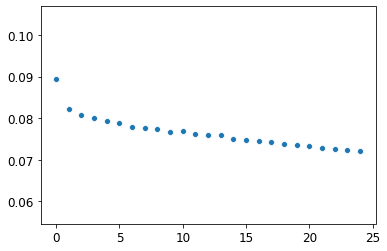

In [344]:
# Plot the loss vs the number of epoch
sns.scatterplot(x = range(len(historycomb_dict['loss'])), y=historycomb_dict['loss'])

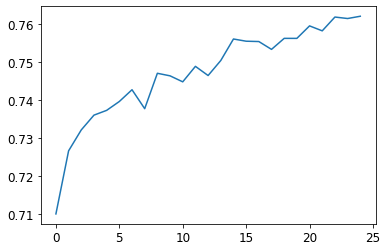

In [345]:
# Plot the training f1 vs the number of epochs
sns.lineplot(x = range(len(historycomb_dict['f1_m'])), y=historycomb_dict['f1_m'])

In [346]:
historycomb_dict['f1_m'][0:5]

[0.7100349822269544,
 0.7266727853645086,
 0.7321938805263556,
 0.7360863932986875,
 0.7373464638099992]

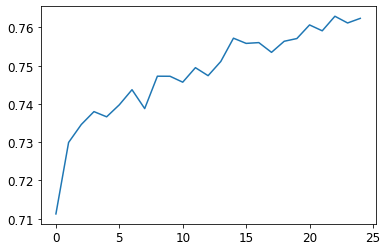

In [347]:
# Plot the training precision vs the number of epochs
sns.lineplot(x = range(len(historycomb_dict['precision_m'])), y=historycomb_dict['precision_m'])

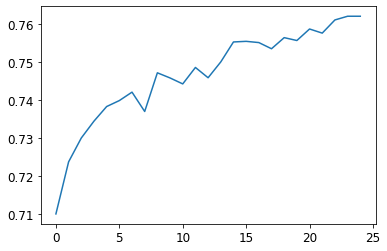

In [348]:
# Plot the training recall vs the number of epochs
sns.lineplot(x = range(len(historycomb_dict['recall_m'])), y=historycomb_dict['recall_m'])

In [349]:
y_hat_test_comb = model2.predict(xtest_comb)

In [350]:
# Print the loss and accuracy for the training set 
results_traincomb = model2.evaluate(xtrain_comb, ytrain_comb_array)
results_traincomb

18466/18466 [==============================] - 0s 17us/step


[0.4925457074529958,
 0.7357846853677028,
 0.734779098420467,
 0.7366010854423182,
 0.733131159969674]

In [351]:
# Print the loss and accuracy for the test set (it prints the evaluation metric values given to it)
results_testcomb = model2.evaluate(xtest_comb, ytest_comb_array)
results_testcomb

10554/10554 [==============================] - 0s 17us/step


[0.4832308204805252,
 0.7421830585559978,
 0.741300833141666,
 0.7427685324477499,
 0.7400037900322153]

### Evaluating results

In [352]:
np.sum(ytest_comb)

676.0

In [353]:
ynewcomb = model.predict_classes(xtest_comb)

In [354]:
len(ynewcomb) - np.sum(ynewcomb)

3156

In [357]:
np.sum(ynewcomb)

7398

In [358]:
len(ynewcomb)

10554

### Evaluating using sklearn metrics
https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

In [355]:
print(xtest_comb.shape)
print(y_pred.shape)
print(ytest_comb.shape)

(10554, 13)
(10554, 2)
(10554,)


In [356]:
y_pred = model2.predict(xtest_comb, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(ytest_comb, y_pred_bool))

10554/10554 [==============================] - 0s 5us/step
              precision    recall  f1-score   support

         0.0       0.81      0.27      0.40      9878
         1.0       0.01      0.09      0.01       676

    accuracy                           0.26     10554
   macro avg       0.41      0.18      0.21     10554
weighted avg       0.76      0.26      0.38     10554



## Combined model with more layers

In [608]:
# Initialize a sequential model
model2morelayers = Sequential()

# Two layers with relu activation
model2morelayers.add(Dense(50, activation='relu', input_shape=(13,)))
model2morelayers.add(Dense(25, activation='relu'))
model2morelayers.add(Dropout(0.3))
model2morelayers.add(Dense(50, activation='relu'))
model2morelayers.add(Dense(25, activation='tanh'))
model2morelayers.add(Dense(50, activation='relu'))
model2morelayers.add(Dropout(0.2))
model2morelayers.add(Dense(25, activation='relu'))
model2morelayers.add(Dense(25, activation='tanh'))
model2morelayers.add(Dense(50, activation='relu'))
model2morelayers.add(Dropout(0.2))
model2morelayers.add(Dense(25, activation='relu'))
model2morelayers.add(Dense(25, activation='tanh'))
model2morelayers.add(Dense(50, activation='relu'))

# One layer with softmax activation 
model2morelayers.add(Dense(1, activation='sigmoid'))

In [609]:
# Compile the model
model2morelayers.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['acc', f1_m, precision_m, recall_m]) 

In [610]:
# Train the model 
history_combmorelayers = model2morelayers.fit(xtrain_comb, ytrain_comb,
                    batch_size=32,
                    epochs=20,
                    validation_data=(xvalid_comb, yvalid_comb))
#                          class_weight = {0: len(ytrain_comb) - int(np.sum(ytrain_comb)),
#                                         1: int(np.sum(ytrain_comb))})

Train on 18466 samples, validate on 7912 samples
Epoch 1/20
18466/18466 [==============================] - 2s 117us/step - loss: 0.3369 - acc: 0.9078 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.3888 - val_acc: 0.8713 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/20
18466/18466 [==============================] - 2s 88us/step - loss: 0.3022 - acc: 0.9083 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.3603 - val_acc: 0.8713 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/20
18466/18466 [==============================] - 2s 89us/step - loss: 0.2822 - acc: 0.9083 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.3415 - val_acc: 0.8713 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/20
18466/18466 [==============================] - 1s 80us/step - loss: 0.2644 - acc: 0.

In [611]:
history_combmorelayers_dict = history_comb.history
history_combmorelayers_dict.keys()

dict_keys(['val_loss', 'val_acc', 'val_f1_m', 'val_precision_m', 'val_recall_m', 'loss', 'acc', 'f1_m', 'precision_m', 'recall_m'])

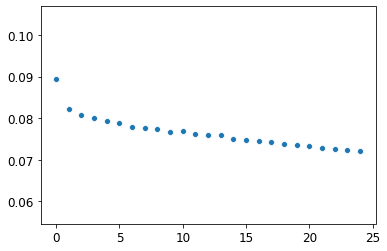

In [612]:
# Plot the loss vs the number of epoch
sns.scatterplot(x = range(len(history_combmorelayers_dict['loss'])), y=history_combmorelayers_dict['loss'])

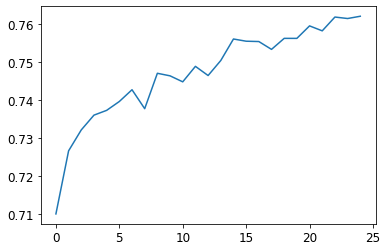

In [613]:
# Plot the training f1 vs the number of epochs
sns.lineplot(x = range(len(history_combmorelayers_dict['f1_m'])), y=history_combmorelayers_dict['f1_m'])

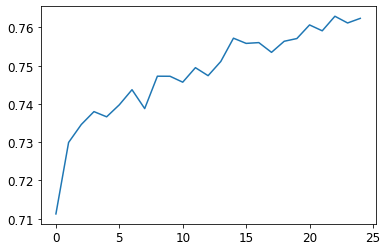

In [614]:
# Plot the training precision vs the number of epochs
sns.lineplot(x = range(len(history_combmorelayers_dict['precision_m'])), y=history_combmorelayers_dict['precision_m'])

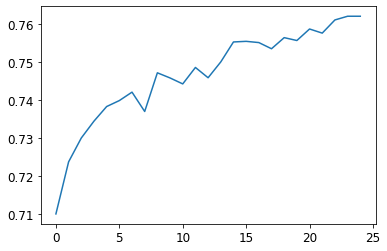

In [615]:
# Plot the training recall vs the number of epochs
sns.lineplot(x = range(len(history_combmorelayers_dict['recall_m'])), y=history_combmorelayers_dict['recall_m'])

In [616]:
y_hat_test_comb = model2morelayers.predict(xtest_comb)

In [617]:
# Print the loss and accuracy for the training set 
results_traincomb = model2morelayers.evaluate(xtrain_comb, ytrain_comb)
results_traincomb

18466/18466 [==============================] - 1s 28us/step


[0.23832275999148528, 0.9082638362395754, 0.0, 0.0, 0.0]

In [618]:
# Print the loss and accuracy for the test set (it prints the evaluation metric values given to it)
results_testcomb = model2morelayers.evaluate(xtest_comb, ytest_comb)
results_testcomb

10554/10554 [==============================] - 0s 27us/step


[0.18471935225439942, 0.9359484555618722, 0.0, 0.0, 0.0]

In [619]:
y_pred = model2morelayers.predict_classes(xtest_comb)
print(classification_report(ytest_comb, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97      9878
         1.0       0.00      0.00      0.00       676

    accuracy                           0.94     10554
   macro avg       0.47      0.50      0.48     10554
weighted avg       0.88      0.94      0.90     10554



/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [620]:
len(ytest_comb)

10554

In [604]:
np.sum(ytest_comb)

676.0

In [564]:
np.sum(y_pred)

0

## 1d CNN
- 1d notebook https://github.com/Gruschtel/1D-CNN/blob/master/1D_CNN_01.ipynb

In [618]:
# total number of vowels in training set
vowelsintrain = np.sum(y_train20)
print(f"total number of vowels in training set is {vowelsintrain}")
print(f"the percent of training set that are vowels {vowelsintrain/len(labels_20)}")

total number of vowels in training set is 847.0
the percent of training set that are vowels 0.03210887448349065


In [619]:
# dimensions
print(x_train20.shape)
print(x_valid20.shape)
print(x_test20.shape)

(9233, 13)
(3956, 13)
(5277, 13)


In [652]:
# reshape the sets before feeding it into the model 
xtrain = x_train20.reshape(x_train20.shape[0], x_train20.shape[1], 1)
xval = x_valid20.reshape(x_valid20.shape[0], x_valid20.shape[1], 1)
xtest = x_test20.reshape(x_test20.shape[0], x_test20.shape[1], 1)

In [654]:
xtest.shape

(5277, 13, 1)

In [655]:
model1d = keras.models.Sequential()
model1d.add(Conv1D(1, kernel_size=1, input_shape = (xtrain.shape[0], xtrain.shape[1])))
model1d.add(GlobalMaxPooling1D())
model1d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 9233, 1)           14        
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 1)                 0         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


In [656]:
# model.add(Flatten())
model1d.add(Dense(250))
model1d.add(Activation('relu'))
model1d.add(Dense(2))
model1d.add(Activation('sigmoid'))
model1d.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])   

In [657]:
model1d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 9233, 1)           14        
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 1)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 250)               500       
_________________________________________________________________
activation_5 (Activation)    (None, 250)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 502       
_________________________________________________________________
activation_6 (Activation)    (None, 2)                 0         
Total params: 1,016
Trainable params: 1,016
Non-trainable params: 0
_________________________________________________________________


In [659]:
# history = model1d.fit(x_train20, y_train20, batch_size=32, epochs=3, validation_data=(x_valid20, y_valid20))
a = model1d.fit(xtrain, y_train20)

ValueError: Error when checking input: expected conv1d_7_input to have shape (9233, 13) but got array with shape (13, 1)

In [646]:
x_valid20.shape

(3956, 13)

In [648]:
x_val = x_valid20.reshape(3956, 13, 1)

In [649]:
x_val.shape

(3956, 13, 1)

In [650]:
results = model1d.fit(x_val, y_valid20)
print ("Accuracy on test set:" , results)
print('Test loss:', results[0])
print('Test accuracy:', results[1])

ValueError: Error when checking input: expected conv1d_6_input to have shape (9233, 13) but got array with shape (13, 1)

## CNN take 2

In [ ]:
# make sure the layers are in the correct shape (just speaker 2)
xtrain = xtrain_comb.reshape(xtrain_comb.shape[0], xtrain_comb.shape[1], 1)
xval = xvalid_comb.reshape(xvalid_comb.shape[0], xvalid_comb.shape[1], 1)
xtest = xtest_comb.reshape(xtest_comb.shape[0], xtest_comb.shape[1], 1)

In [678]:
print(xtrain.shape)
print(ytrain_comb.shape)
print(xtest_comb.shape)

(18466, 13, 1)
(18466,)
(10554, 13)


In [868]:
modelcnn = Sequential()
modelcnn.add(Conv1D(1, 2, activation='relu',
                        input_shape=(13, 1)))
modelcnn.add(MaxPooling1D(2))
modelcnn.add(Dropout(0.2))

modelcnn.add(Conv1D(1, 1, activation='tanh'))
modelcnn.add(MaxPooling1D(1))

modelcnn.add(Conv1D(1, 1, activation='tanh'))
modelcnn.add(MaxPooling1D(2))

modelcnn.add(Conv1D(1, 1, activation='relu'))
modelcnn.add(MaxPooling1D(1))
modelcnn.add(Dropout(0.1))

modelcnn.add(Flatten())
# modelcnn.add(Dense(2, activation='relu'))
modelcnn.add(Dense(1, activation='sigmoid'))

In [869]:
modelcnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m, f1_m])

In [870]:
es = EarlyStopping(monitor = 'val_acc', mode = 'max', patience = 3, min_delta = 1)
mcb = ModelCheckpoint('historycnn', monitor='val_acc', mode = 'max', verbose = 1, save_best_only=True)

In [871]:
historycnn = modelcnn.fit(xtrain, ytrain_comb,
                    epochs=50,
                    batch_size=128,
                     validation_data=(xval, yvalid_comb),
                         callbacks = [es, mcb])

Train on 18466 samples, validate on 7912 samples
Epoch 1/50
18466/18466 [==============================] - 2s 124us/step - loss: 0.6903 - acc: 0.6380 - precision_m: 0.1179 - recall_m: 0.4557 - f1_m: 0.1846 - val_loss: 0.6435 - val_acc: 0.7127 - val_precision_m: 0.1159 - val_recall_m: 0.1407 - val_f1_m: 0.1056

Epoch 00001: val_acc improved from -inf to 0.71271, saving model to historycnn
Epoch 2/50
18466/18466 [==============================] - 0s 25us/step - loss: 0.6095 - acc: 0.7389 - precision_m: 0.1016 - recall_m: 0.2319 - f1_m: 0.1370 - val_loss: 0.5855 - val_acc: 0.7935 - val_precision_m: 0.1168 - val_recall_m: 0.0879 - val_f1_m: 0.0828

Epoch 00002: val_acc improved from 0.71271 to 0.79348, saving model to historycnn
Epoch 3/50
18466/18466 [==============================] - 0s 27us/step - loss: 0.5469 - acc: 0.7994 - precision_m: 0.1035 - recall_m: 0.1608 - f1_m: 0.1206 - val_loss: 0.5144 - val_acc: 0.8713 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0

In [866]:
# Output (probability) predictions for the test set 
y_hat = modelcnn.predict(xtest)

In [867]:
# Print the loss and accuracy for the training set 
results_traincnn = modelcnn.evaluate(xtrain, ytrain_comb)
results_traincnn

18466/18466 [==============================] - 1s 38us/step


[0.5112121905625144, 0.9082638362395754, 0.0, 0.0, 0.0]

In [861]:
# Print the loss and accuracy for the test set (it prints the evaluation metric values given to it)
results_testcnn = modelcnn.evaluate(xtest, ytest_comb)
results_testcnn

10554/10554 [==============================] - 0s 41us/step


[0.4967259285247572, 0.9359484555618722, 0.0, 0.0, 0.0]

### Evaluating using sklearn

In [836]:
modelcnn.predict(xtest)

array([[0.04723811],
       [0.04723811],
       [0.04723811],
       ...,
       [0.02757193],
       [0.02757194],
       [0.02757196]], dtype=float32)

In [837]:
ynew = modelcnn.predict_classes(xtest)
print(classification_report(ytest_comb, ynew, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97      9878
         1.0       0.17      0.00      0.01       676

    accuracy                           0.94     10554
   macro avg       0.55      0.50      0.49     10554
weighted avg       0.89      0.94      0.90     10554



In [838]:
ynew_prob = modelcnn.predict(xtest)

In [839]:
predictions = ynew_prob.round()

In [840]:
np.sum(predictions)

12.0

# CNN with bigger mfcc

In [140]:
signal_6 = downsample_dictionary['ENF_06']['Filter_25_sigma_1.5'][0]
signal_2 = downsample_dictionary['ENF_02']['Filter_25_sigma_1.5'][0]

In [141]:
mfcc6_62 = speechpy.feature.mfcc(signal = signal_6, sampling_frequency = 8000, frame_length = 0.02, 
                             frame_stride = 0.02, num_cepstral = 62)
mfcc2_62 = speechpy.feature.mfcc(signal = signal_2, sampling_frequency = 8000, frame_length = 0.02, 
                             frame_stride = 0.02, num_cepstral = 62)

In [142]:
xtrain_comb40 = np.concatenate((mfcc2_62[train_split_point:], mfcc6_62[train_split_point:]))
ytrain_comb = np.concatenate((labels_20[train_split_point:], labels_6[train_split_point:]))

xvalid_comb40 = np.concatenate((mfcc2_62[train_split_point:test_split_point], mfcc6_62[train_split_point:test_split_point]))
yvalid_comb = np.concatenate((labels_20[train_split_point:test_split_point], labels_6[train_split_point:test_split_point]))

xtest_comb40 = np.concatenate((mfcc2_62[test_split_point:], mfcc6_62[test_split_point:]))
ytest_comb = np.concatenate((labels_20[test_split_point:], labels_6[test_split_point:]))

In [143]:
xtrain40 = xtrain_comb40.reshape(xtrain_comb40.shape[0], xtrain_comb40.shape[1], 1)
xval40 = xvalid_comb40.reshape(xvalid_comb40.shape[0], xvalid_comb40.shape[1], 1)
xtest40 = xtest_comb40.reshape(xtest_comb40.shape[0], xtest_comb40.shape[1], 1)

In [144]:
print(xtrain.shape)
print(xtrain40.shape)
print(xtest40.shape)

NameError: name 'xtrain' is not defined

In [1393]:
# should i try larger maxpooling windows?
# try larger kernal size second art in conv1d
modelcnn2 = Sequential()
modelcnn2.add(Conv1D(2, 5, activation='relu',
                        input_shape=(40, 1)))
modelcnn2.add(MaxPooling1D(1))
modelcnn2.add(Dropout(0.2))

modelcnn2.add(Conv1D(2, 5, activation='tanh'))
modelcnn2.add(MaxPooling1D(1))

modelcnn2.add(Conv1D(2, 1, activation='relu'))
modelcnn2.add(MaxPooling1D(1))
modelcnn2.add(Dropout(0.2))

modelcnn2.add(Flatten())
# modelcnn.add(Dense(2, activation='relu'))
modelcnn2.add(Dense(1, activation='sigmoid'))

In [1394]:
modelcnn2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m, f1_m])

In [1395]:
es = EarlyStopping(monitor = 'val_acc', mode = 'max', patience = 3, min_delta = 1)
mcb = ModelCheckpoint('historycnn', monitor='val_acc', mode = 'max', verbose = 1, save_best_only=True)

In [1396]:
historycnn2 = modelcnn2.fit(xtrain40, ytrain_comb,
                    epochs=50,
                    batch_size=128,
                     validation_data=(xval40, yvalid_comb),
                         callbacks = [es, mcb])

Train on 18466 samples, validate on 7912 samples
Epoch 1/50
18466/18466 [==============================] - 3s 168us/step - loss: 0.4875 - acc: 0.8116 - precision_m: 0.0554 - recall_m: 0.1475 - f1_m: 0.0702 - val_loss: 0.4103 - val_acc: 0.8713 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00

Epoch 00001: val_acc improved from -inf to 0.87133, saving model to historycnn
Epoch 2/50
18466/18466 [==============================] - 1s 45us/step - loss: 0.3202 - acc: 0.9083 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 0.3931 - val_acc: 0.8713 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00

Epoch 00002: val_acc did not improve from 0.87133
Epoch 3/50
18466/18466 [==============================] - 1s 44us/step - loss: 0.3100 - acc: 0.9083 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 0.3813 - val_acc: 0.8713 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00

In [1397]:
# Output (probability) predictions for the test set 
y_hat = modelcnn2.predict(xtest40)

In [1398]:
# Print the loss and accuracy for the training set 
results_traincnn = modelcnn2.evaluate(xtrain40, ytrain_comb)
results_traincnn

18466/18466 [==============================] - 1s 63us/step


[0.28634920701316763, 0.9082638362395754, 0.0, 0.0, 0.0]

In [1399]:
# Print the loss and accuracy for the test set (it prints the evaluation metric values given to it)
results_testcnn = modelcnn2.evaluate(xtest40, ytest_comb)
results_testcnn

10554/10554 [==============================] - 1s 63us/step


[0.22261659374613416, 0.9359484555618722, 0.0, 0.0, 0.0]

### Evaluating using sklearn

In [1400]:
ynew = modelcnn2.predict_classes(xtest40)
print(classification_report(ytest_comb, ynew, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97      9878
         1.0       0.00      0.00      0.00       676

    accuracy                           0.94     10554
   macro avg       0.47      0.50      0.48     10554
weighted avg       0.88      0.94      0.90     10554



In [1401]:
ynew_prob40 = modelcnn2.predict(xtest40)

In [1402]:
predictions40 = ynew_prob40.round()

In [1403]:
np.sum(predictions40)

0.0

# Mimicking my best neural net as cnn

In [1433]:
modelcnn3 = Sequential()
modelcnn3.add(Conv1D(1,1, activation='relu',
                        input_shape=(40, 1)))
modelcnn3.add(MaxPooling1D(1))

modelcnn3.add(Conv1D(1, 1, activation='tanh'))
modelcnn3.add(MaxPooling1D(1))
modelcnn3.add(Dropout(0.3))

modelcnn3.add(Conv1D(1, 1, activation='tanh'))
modelcnn3.add(MaxPooling1D(1))
modelcnn3.add(Dropout(0.2))
modelcnn3.add(Conv1D(1, 1, activation='relu'))
modelcnn3.add(MaxPooling1D(1))

modelcnn3.add(Flatten())
# modelcnn.add(Dense(2, activation='relu'))
modelcnn3.add(Dense(1, activation='sigmoid'))

In [1434]:
modelcnn3.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m, f1_m])

In [1435]:
es = EarlyStopping(monitor = 'val_acc', mode = 'max', patience = 3, min_delta = 1)
mcb = ModelCheckpoint('historycnn3', monitor='val_acc', mode = 'max', verbose = 1, save_best_only=True)

In [1436]:
historycnn3 = modelcnn3.fit(xtrain40, ytrain_comb,
                    epochs=50,
                    batch_size=256,
                     validation_data=(xval40, yvalid_comb),
                         callbacks = [es, mcb])

Train on 18466 samples, validate on 7912 samples
Epoch 1/50
18466/18466 [==============================] - 3s 168us/step - loss: 0.4677 - acc: 0.8266 - precision_m: 0.0239 - recall_m: 0.0798 - f1_m: 0.0350 - val_loss: 0.3875 - val_acc: 0.8713 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00

Epoch 00001: val_acc improved from -inf to 0.87133, saving model to historycnn3
Epoch 2/50
18466/18466 [==============================] - 0s 26us/step - loss: 0.3147 - acc: 0.9083 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 0.3932 - val_acc: 0.8713 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00

Epoch 00002: val_acc did not improve from 0.87133
Epoch 3/50
18466/18466 [==============================] - 0s 26us/step - loss: 0.3119 - acc: 0.9083 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 0.3952 - val_acc: 0.8713 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+0

# Best neural net with all data

In [1452]:
xtrain_comb40.shape

(18466, 40)

In [1442]:
xtrain40.shape

(18466, 40, 1)

In [1459]:
# Initialize a sequential model
model_alldata = Sequential()
# Two layers with relu activation 8 layers
model_alldata.add(Dense(50, activation='relu', input_shape=(40,1)))
model_alldata.add(Dense(25, activation='relu'))
model_alldata.add(Dense(25, activation='tanh'))
model_alldata.add(Dropout(0.3))
model_alldata.add(Dense(25, activation='relu'))
model_alldata.add(Dense(25, activation='tanh'))
model_alldata.add(Dense(25, activation='relu'))
# model.add(Dropout(0.1))
model_alldata.add(Dense(25, activation='tanh'))
model_alldata.add(Dense(25, activation='relu'))
# One layer with sigmoid activation 
model_alldata.add(Dense(1, activation='sigmoid'))

In [1460]:
# Compile the model
model_alldata.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy', recall_m, precision_m, f1_m]) 

In [1461]:
es = EarlyStopping(monitor = 'val_acc', mode = 'max', patience = 5, min_delta = 1)
mcb = ModelCheckpoint('history_alldata', monitor= 'val_acc', mode = 'max', verbose = 1, save_best_only=True)

In [1462]:
# Train the model 
history_alldata = model.fit(xtrain_comb40, ytrain_comb,
                    batch_size=128,
                    epochs=75,
                    validation_data=(xvalid_comb40, yvalid_comb), 
                   callbacks = [es, mcb])

Train on 18466 samples, validate on 7912 samples
Epoch 1/75
18466/18466 [==============================] - 3s 140us/step - loss: 0.2438 - acc: 0.9083 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 0.3097 - val_acc: 0.8713 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00

Epoch 00001: val_acc improved from -inf to 0.87133, saving model to history_alldata
Epoch 2/75
18466/18466 [==============================] - 0s 27us/step - loss: 0.2430 - acc: 0.9083 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 0.3111 - val_acc: 0.8713 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00

Epoch 00002: val_acc did not improve from 0.87133
Epoch 3/75
18466/18466 [==============================] - 1s 27us/step - loss: 0.2426 - acc: 0.9083 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 0.3098 - val_acc: 0.8713 - val_recall_m: 0.0000e+00 - val_precis

In [1463]:
#history
history_alldata_dict = history_alldata.history
history_alldata_dict.keys()

dict_keys(['val_loss', 'val_acc', 'val_recall_m', 'val_precision_m', 'val_f1_m', 'loss', 'acc', 'recall_m', 'precision_m', 'f1_m'])

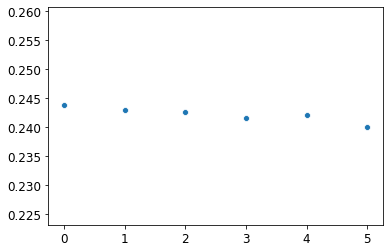

In [1464]:
# Plot the loss vs the number of epoch
sns.scatterplot(x = range(len(history_alldata_dict['loss'])), y=history_alldata_dict['loss'])

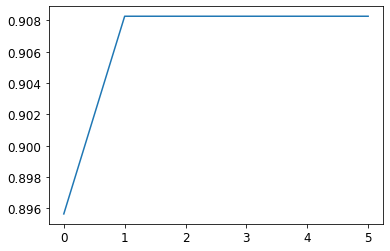

In [1456]:
# Plot the training accuracy vs the number of epochs
sns.lineplot(x = range(len(history_alldata_dict['acc'])), y=history_alldata_dict['acc'])

In [1026]:
# Output (probability) predictions for the test set 
y_hat_test = model_alldata.predict(x_test20)

In [1027]:
# Print the loss and accuracy for the training set 
results_train = model.evaluate(x_train20, y_train20)
results_train

9233/9233 [==============================] - 0s 51us/step


[0.14528632665128258,
 0.9356655474926893,
 0.16279780850513234,
 0.18777917749146064,
 0.1663239472454397]

In [1028]:
# Print the loss and accuracy for the test set (it prints the evaluation metric values given to it)
results_test = model.evaluate(x_test20, y_test20)
results_test

5277/5277 [==============================] - 0s 42us/step


[0.11651282742607513,
 0.9488345650938033,
 0.12853996975529888,
 0.14507236384929798,
 0.1256594647958194]

### Evaluating the model 

In [1029]:
ynew = model.predict_classes(x_test20)

In [1030]:
ynew.sum()

350

In [ ]:
ynew = model.predict_classes(x_test20)
print(classification_report(y_test20, ynew, zero_division=0))

# Comparing best vanilla neural net w/ hampel filter

### Retrieving the hampel filter version

In [150]:
filter1point5 = downsample_dictionary['ENF_02']['Filter_25_sigma_1.5'][1]
len(filter1point5)

371037

In [151]:
len(downsample_dictionary['ENF_02']['Filter_25_sigma_1.5'][0])/ 8000

527.604125

In [152]:
time_of_vowel_after_filter = (np.array(filter1point5)) / 8000

In [153]:
time_of_vowel_after_filter

array([  2.004875,   2.005   ,   2.005125, ..., 525.579875, 525.58    ,
       525.589125])

In [154]:
vowel_after_filter_index = [make_into_02_chunk(x) for x in time_of_vowel_after_filter]

In [155]:
vowel_after_filter_index[0:5]

[2.0, 2.0, 2.0, 2.0, 2.0]

In [156]:
unique_vowel_after_filter_index = np.unique(vowel_after_filter_index)

In [157]:
print(f"length of unique vowels = {len(unique_vowel_after_filter_index)}")
print(f"length of vowels non-uniquely separated = {len(vowel_after_filter_index)}")

length of unique vowels = 22798
length of vowels non-uniquely separated = 371037


In [158]:
test_split_point

21102

In [159]:
test_split_point / 50

422.04

In [160]:
len(unique_vowel_after_filter_index)

22798

In [161]:
unique_vowel_after_filter_index

array([  2.  ,   2.02,   2.04, ..., 525.54, 525.56, 525.58])

In [162]:
len(many_after_filter_vowels)

NameError: name 'many_after_filter_vowels' is not defined

In [163]:
len(test_unique_after_filter_vowels[0])

NameError: name 'test_unique_after_filter_vowels' is not defined

In [164]:
test_unique_after_filter_vowels

NameError: name 'test_unique_after_filter_vowels' is not defined

In [165]:
many_after_filter_vowels = np.where(unique_vowel_after_filter_index > (test_split_point / 50),
                                          unique_vowel_after_filter_index, 0)

In [166]:
many_after_filter_vowels[-50:]

array([524.44, 524.46, 524.48, 524.5 , 524.52, 524.54, 524.56, 524.58,
       524.6 , 524.62, 524.64, 524.66, 524.68, 524.7 , 524.72, 524.74,
       524.76, 524.78, 524.8 , 524.82, 524.86, 524.88, 524.9 , 524.92,
       524.94, 524.96, 524.98, 525.02, 525.04, 525.08, 525.1 , 525.12,
       525.14, 525.18, 525.22, 525.24, 525.26, 525.28, 525.3 , 525.32,
       525.34, 525.36, 525.4 , 525.42, 525.48, 525.5 , 525.52, 525.54,
       525.56, 525.58])

In [167]:
len(np.nonzero(many_after_filter_vowels))

1

In [168]:
len(many_after_filter_vowels)

22798

In [169]:
test_unique_after_filter_vowels = np.nonzero(many_after_filter_vowels)

In [170]:
test_unique_after_filter_vowels

(array([18231, 18232, 18233, ..., 22795, 22796, 22797]),)

In [171]:
len(test_unique_after_filter_vowels[0])

4567

In [172]:
test_unique_after_filter_vowels[0]

array([18231, 18232, 18233, ..., 22795, 22796, 22797])

In [173]:
22797 - 18231

4566

### Hampel filter sigma 3

In [174]:
filter1point5_sig3 = downsample_dictionary['ENF_02']['Filter_25'][1]

In [175]:
time_of_vowel_after_filter_sig3 = (np.array(filter1point5_sig3)) / 8000

In [176]:
vowel_after_filter_index_sig3 = [make_into_02_chunk(x) for x in time_of_vowel_after_filter_sig3]

In [177]:
vowel_after_filter_index_sig3[0:5]

[2.04, 2.04, 2.6, 2.6, 2.84]

In [178]:
unique_vowel_after_filter_index_sig3 = np.unique(vowel_after_filter_index_sig3)

In [179]:
len(unique_vowel_after_filter_index_sig3)

6474

In [180]:
unique_vowel_after_filter_index_sig3

array([  2.04,   2.6 ,   2.84, ..., 525.3 , 525.32, 525.56])

In [181]:
many_after_filter_vowels_sig3 = np.where(unique_vowel_after_filter_index_sig3 > (test_split_point / 50),
                                          unique_vowel_after_filter_index_sig3, 0)

In [182]:
many_after_filter_vowels_sig3

array([  0.  ,   0.  ,   0.  , ..., 525.3 , 525.32, 525.56])

### Turning predictions by neural net into indices

In [248]:
# finding number of indices in total 
test_split_point + len(best_neuralnet_predictions)
26379 / 50

527.58

In [249]:
pre_test = np.zeros(test_split_point)

In [250]:
pre_test.shape

(21102,)

In [251]:
best_neuralnet_predictions.shape

(5277, 1)

In [252]:
reshaped_best_neuralnet_predictions = np.reshape(best_neuralnet_predictions, 5277)

In [253]:
list_best_neuralnet_predictions = list(best_neuralnet_predictions)
best_neuralnet_predictions_indices = [idx + test_split_point for idx, x in enumerate(list_best_neuralnet_predictions)]

In [254]:
best_neuralnet_predictions_indices[0:5]

[21102, 21103, 21104, 21105, 21106]

In [255]:
# do final_neuralnet_predictions[0][1][0] to get the value of the neural net predictions
final_neuralnet_predictions = list(zip(best_neuralnet_predictions_indices, best_neuralnet_predictions))

### Cross comparing the two

In [1156]:
len(final_neuralnet_predictions)

5277

In [1159]:
len(test_unique_after_filter_vowels[0])

4567

In [1161]:
final_neuralnet_predictions[0][0]

21102

In [1208]:
final_neuralnet_predictions[2][0]

21104

In [1129]:
len(final_neuralnet_predictions) == len(test_unique_after_filter_vowels)

False

In [1218]:
type(final_neuralnet_predictions)

list

In [1219]:
len(final_neuralnet_predictions)

5277

In [1318]:
final_neuralnet_predictions_vowel = [x[0] for x in final_neuralnet_predictions if x[1][0] == 1]

In [1238]:
# yay!
len(final_neuralnet_predictions_vowel)

350

In [1240]:
type(final_neuralnet_predictions_vowel)

list

In [1241]:
type(final_neuralnet_predictions)

list

In [1242]:
final_neuralnet_predictions_vowel[0:5]

[21120, 21122, 21123, 21124, 21125]

In [1243]:
final_neuralnet_predictions[0:5]

[(21102, array([0], dtype=int32)),
 (21103, array([0], dtype=int32)),
 (21104, array([0], dtype=int32)),
 (21105, array([0], dtype=int32)),
 (21106, array([0], dtype=int32))]

In [1143]:
# try to match the vowel predictions from hampel filter with 1s in best_neuralnet_predictions
best_neuralnet_predictions.shape

(5277, 1)

In [1172]:
test_unique_after_filter_vowels[0][0]

18231

In [1239]:
# do this, but on the list of final_neuralnet_predictions that is only vowels
for x in range(len(final_neuralnet_predictions)):
    if final_neuralnet_predictions[x][0] in list(test_unique_after_filter_vowels[0]):
#         print(final_neuralnet_predictions[x][0])
        pass

TypeError: 'int' object is not subscriptable

In [1252]:
overlap_list = []
hamp_filt_indices = list(test_unique_after_filter_vowels[0])
for x in final_neuralnet_predictions_vowel:
    if x in hamp_filt_indices:
        overlap_list.append(x)

In [1254]:
len(overlap_list)

129

### Checking how well each model performed

In [1261]:
len(y_train20)

9233

In [1268]:
# overlap_list

In [1258]:
actually_vowel_indices = [idx + test_split_point for idx, x in enumerate(y_train20) if x == 1]

In [1260]:
len(actually_vowel_indices)

847

In [1263]:
total_correct = set(overlap_list).intersection(actually_vowel_indices)

In [1265]:
len(total_correct)

26

In [1266]:
26 / 847

0.030696576151121605

# Comparing all of the models
https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/

In [145]:
# I need the data in the 0s and 1s format for each possible point 
y_test20

array([0., 0., 0., ..., 0., 0., 0.])

In [146]:
len(y_test20)

5277

In [269]:
# neural net predictions
neural_net_binary = [x[0] for x in best_neuralnet_predictions]
precision_neural_net = precision_score(y_test20, neural_net_binary)
recall_neural_net = recall_score(y_test20, neural_net_binary)
f1_neural_net  = f1_score(y_test20, neural_net_binary)

In [267]:
print(precision_neural_net)
print(recall_neural_net)
print(f1_neural_net)

0.5749385749385749
0.6923076923076923
0.6281879194630872


In [270]:
# hampel filter 1.5
nonzero_many_after_filter_vowels = np.array([x for x in many_after_filter_vowels if x != 0])
all_hamp_filt_vowels = nonzero_many_after_filter_vowels * 50
hamp_binary = []
for x in range(21102, (21102 + len(y_test20))):
    if x in all_hamp_filt_vowels:
        hamp_binary.append(1)
    else:
        hamp_binary.append(0)
precision_hamp_15 = precision_score(y_test20, hamp_binary)
recall_hamp_15 = recall_score(y_test20, hamp_binary)
f1_hamp_15  = f1_score(y_test20, hamp_binary)

In [271]:
# hampel filter 3
nonzero_many_after_filter_vowels_sig3 = np.array([x for x in many_after_filter_vowels_sig3 if x != 0])
all_hamp_filt_vowels_sig3 = nonzero_many_after_filter_vowels_sig3 * 50
hamp_binary_sig3 = []
for x in range(21102, (21102 + len(y_test20))):
    if x in all_hamp_filt_vowels_sig3:
        hamp_binary_sig3.append(1)
    else:
        hamp_binary_sig3.append(0)
precision_hamp_3 = precision_score(y_test20, hamp_binary_sig3)
recall_hamp_3 = recall_score(y_test20, hamp_binary_sig3)
f1_hamp_3  = f1_score(y_test20, hamp_binary_sig3)

In [1364]:
# neural net confusion matrix
confusion_matrix(y_test20, neural_net_binary)

array([[4798,  141],
       [ 129,  209]])

In [1370]:
# hampel filter 1.5 confusion matrix
confusion_matrix(y_test20, hamp_binary)

array([[ 892, 4047],
       [  20,  318]])

In [1537]:
# hampel filter 3 confusion matrix
confusion_matrix(y_test20, hamp_binary_sig3)

array([[4045,  894],
       [  84,  254]])

In [278]:
# combined list with hamp 1.5
hampel_array = np.array(hamp_binary)
neural_net_array = np.array(neural_net_binary)
combined_array = np.where((hampel_array == 1) & (neural_net_array == 1), 1, 0)

In [279]:
confusion_matrix(y_test20, combined_array)
precision_combined15 = precision_score(y_test20, combined_array)
recall_combined15 = recall_score(y_test20, combined_array)
f1_combined15  = f1_score(y_test20, combined_array)

In [273]:
# combined list with hamp 1.5
hampel_array_sig3 = np.array(hamp_binary_sig3)
neural_net_array = np.array(neural_net_binary)
combined_array_sig3 = np.where((hampel_array_sig3 == 1) & (neural_net_array == 1), 1, 0)

In [276]:
confusion_matrix(y_test20, combined_array_sig3)
precision_combined3 = precision_score(y_test20, combined_array_sig3)
recall_combined3 = recall_score(y_test20, combined_array_sig3)
f1_combined3  = f1_score(y_test20, combined_array_sig3)

In [283]:
confusion_matrix_dict = {'orderforeverything': "confusion matrix, precision, recall, f1",
    "neuralnet": [confusion_matrix(y_test20, neural_net_binary), precision_neural_net,
                                      recall_neural_net, f1_neural_net],
                       "hampel filter 1.5": [confusion_matrix(y_test20, hamp_binary), precision_hamp_15,
                                            recall_hamp_15, f1_hamp_15],
                        "hampel filter 3": [confusion_matrix(y_test20, hamp_binary_sig3), precision_hamp_3,
                                           recall_hamp_3, f1_hamp_3],
                        "combined w 1.5": [confusion_matrix(y_test20, combined_array), precision_combined15,
                                          recall_combined15, f1_combined15],
                        "combined w 3": [confusion_matrix(y_test20, combined_array_sig3), precision_combined3,
                                            recall_combined3, f1_combined3]}

In [284]:
confusion_matrix_dict

{'orderforeverything': 'confusion matrix, precision, recall, f1',
 'neuralnet': [array([[4766,  173],
         [ 104,  234]]),
  0.5749385749385749,
  0.6923076923076923,
  0.6281879194630872],
 'hampel filter 1.5': [array([[ 892, 4047],
         [  20,  318]]),
  0.07285223367697595,
  0.9408284023668639,
  0.13523283010844142],
 'hampel filter 3': [array([[4045,  894],
         [  84,  254]]),
  0.22125435540069685,
  0.7514792899408284,
  0.34185733512786004],
 'combined w 1.5': [array([[4783,  156],
         [ 116,  222]]),
  0.5873015873015873,
  0.6568047337278107,
  0.6201117318435754],
 'combined w 3': [array([[4836,  103],
         [ 144,  194]]),
  0.6531986531986532,
  0.5739644970414202,
  0.6110236220472441]}

In [311]:
( 8000 / 63)

126.98412698412699

with open("./Visualizations/confusion_matrix_dict", "wb+") as f:
    pickle.dump(confusion_matrix_dict, f)

## Pretty visualizations of the confusion matrices

### Import confusion matrix dict

In [2]:
with open("./Visualizations/confusion_matrix_dict", "rb+") as f:
    confusion_matrix_dict = pickle.load(f)

In [3]:
confusion_matrix_dict

{'neuralnet': array([[4798,  141],
        [ 129,  209]]), 'hampel filter 1.5': array([[ 892, 4047],
        [  20,  318]]), 'hampel filter 3': array([[4045,  894],
        [  84,  254]]), 'combined w 1.5': array([[4859,   80],
        [ 165,  173]]), 'combined w 3': array([[4859,   80],
        [ 165,  173]])}

### Function to print conf. matrix

In [298]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest',aspect='equal', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
#                  verticalalignment='center',
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

### Printing confusion matrices

Confusion Matrix, without normalization
[[4766  173]
 [ 104  234]]


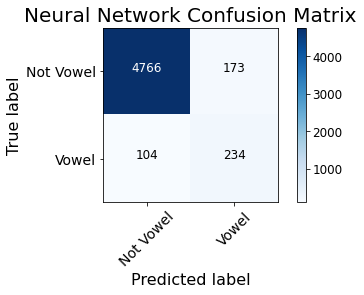

In [299]:
plot_confusion_matrix(confusion_matrix_dict['neuralnet'][0], classes = ['Not Vowel', 'Vowel'], title = 'Neural Network Confusion Matrix')
# plt.savefig('./Visualizations/best_confusion_matrix.png', bbox_inches = 'tight')

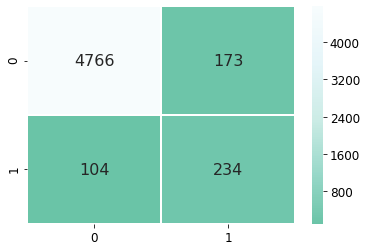

In [293]:
sns.heatmap(confusion_matrix_dict['neuralnet'][0], cmap= 'BuGn_r', annot=True, center =True,
            fmt="d", linewidths=.5,
            annot_kws={"size": 16, 'verticalalignment' : 'center'})

## Final Visualizations

### Plotly

#### Getting the cases where hampel filter and neural net agree

In [329]:
# there's a lot of cases between 0 and a 100, between 100 and 150 is more manageable
overlap_indices = []
for idx, x in enumerate(combined_array_sig3):
    if x == 1:
        overlap_indices.append(idx)

### Making a dataframe

In [332]:
specific_prediction_df = pd.DataFrame({'combined_array_sig3': combined_array_sig3[0:150],
                                       'combined_array': combined_array[0:150],
                                      'hampel_array_sig3': hampel_array_sig3[0:150],
                                      'neural_net_array': neural_net_array[0:150],
                                      'hampel_array_1.5': hampel_array[0:150],
                                      'y_test20': y_test20[0:150]})

In [452]:
specific_prediction_df.head(2)

,combined_array_sig3,combined_array,hampel_array_sig3,neural_net_array,hampel_array_1.5,y_test20
0,0,0,0,0,0,0.0
1,0,0,0,0,0,0.0


In [335]:
specific_prediction_df.y_test20.value_counts()

0.0    103
1.0     47
Name: y_test20, dtype: int64

In [336]:
test_split_point

21102

In [341]:
orig_sp2_data = downsample_dictionary['ENF_02']['original']

In [345]:
# I want the original values for the same time points as I have for hamp filt (1/8000) and 1/50
len(orig_sp2_data) 

4220833

In [344]:
(test_split_point / 50) * 8000

3376320.0

In [371]:
graph_start = int(((test_split_point + 100) / 50) * 8000)
graph_end = int(((test_split_point + 150) / 50) * 8000)

In [349]:
downsample_dictionary['ENF_02'].keys()

dict_keys(['original', 'Filter_25', 'Filter_200_sigma_3', 'Filter_200_sigma_2.5', 'Filter_25_sigma_1.5'])

In [372]:
my_range_orig_sp2_data = orig_sp2_data[graph_start:graph_end]

In [ ]:
my_range_hamp_filt_3 = downsample_dictionary['ENF_02']['Filter_25'][1][3376320:3400320]
my_range_hamp_filt_15 = downsample_dictionary['ENF_02']['Filter_25_sigma_1.5'][1][3376320:3400320]

In [373]:
orig_sr_df = pd.DataFrame({'my_range_orig_sp2_data': my_range_orig_sp2_data,
                           'Sample_number': list(range(0, (graph_end - graph_start)))})

In [393]:
orig_sr_df.head(2)

,my_range_orig_sp2_data,Sample_number
0,-32.253652,0
1,-33.503741,1


fig = px.line(orig_sr_df, x = orig_sr_df['Sample_number'], y = orig_sr_df["my_range_orig_sp2_data"]) 
fig.show()

In [386]:
# I can add dots for each filter and a line that shows where their cut off is 
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=orig_sr_df['Sample_number'], y=orig_sr_df['my_range_orig_sp2_data'],
#                     text=["tweak line smoothness<br>with 'smoothing' in line object"],
#                     hoverinfo='text+name',
#                     line_shape='spline'))
# fig.show()

In [383]:
#424.2 - 425 seconds in original file for "boss's booze"
# get original data for that time (1280 - 7680)
(424.2 * 8000) - graph_start
(425* 8000) - graph_start

7680

In [495]:
graph_start

3392320

In [384]:
smaller_orig_sr_df = orig_sr_df.iloc[1280:7680]

In [387]:
smaller_orig_sr_df.head(2)

,my_range_orig_sp2_data,Sample_number
1280,62.969352,1280
1281,63.032269,1281


fig = go.Figure()
fig.add_trace(go.Scatter(x=smaller_orig_sr_df['Sample_number'], y=smaller_orig_sr_df['my_range_orig_sp2_data'],
                    text=["tweak line smoothness<br>with 'smoothing' in line object"],
                    hoverinfo='text+name',
                    line_shape='spline'))
fig.add_trace(go.Scatter)
fig.show()

In [411]:
# getting hamp filter values for this range 
small_graph_start = int(424.2 * 8000)
small_graph_end = int(425 * 8000)

In [412]:
small_graph_end - small_graph_start

6400

In [434]:
#110 vowel predictions 
sig3_small_graph_index_value = []
for x in range(small_graph_start, small_graph_end):
    if x in downsample_dictionary['ENF_02']['Filter_25'][1]:
        value = downsample_dictionary['ENF_02']['Filter_25'][0][x]
        sig3_small_graph_index_value.append(value)
    else:
        sig3_small_graph_index_value.append(None)

In [446]:
# 792 vowel predictions
sig15_small_graph_index_value = []
for x in range(small_graph_start, small_graph_end):
    if x in downsample_dictionary['ENF_02']['Filter_25_sigma_1.5'][1]:
        value = downsample_dictionary['ENF_02']['Filter_25_sigma_1.5'][0][x]
        sig15_small_graph_index_value.append(value)
    else:
        sig15_small_graph_index_value.append(None)

In [447]:
# my_range_hamp_filt_3 = downsample_dictionary['ENF_02']['Filter_25'][1][3376320:3400320]
# my_range_hamp_filt_15 = downsample_dictionary['ENF_02']['Filter_25_sigma_1.5'][1][3376320:3400320]
smaller_orig_sr_df['Hampel_Filter_3'] = sig3_small_graph_index_value
smaller_orig_sr_df['Hampel_Filter_15'] = sig15_small_graph_index_value

/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### adding traces for where the vowels are 

In [508]:
V1 = [2500 if (x >= ((424.31 * 8000) - (graph_start))) & (x <= ((424.444 * 8000)- (graph_start))) else None for x in range(0, 6400)]

In [502]:
V2 = [1000 if (x >= ((424.504 * 8000) - (graph_start + 1820))) & (x <= ((424.554* 8000)- (graph_start + 1820))) else None for x in range(0, 6400)]
V3 = [2000 if (x>= ((424.684 * 8000)- (graph_start + 1820))) & (x <= ((424.864* 8000)- (graph_start + 1820))) else None for x in range(0, 6400)]

In [509]:
smaller_orig_sr_df['V1'] = V1
smaller_orig_sr_df['V2'] = V2
smaller_orig_sr_df['V3'] = V3

/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

### Graphing with hampel filter values 

In [511]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=smaller_orig_sr_df['Sample_number'], y=smaller_orig_sr_df['my_range_orig_sp2_data'],
                    text=["tweak line smoothness<br>with 'smoothing' in line object"],
                    hoverinfo='text+name', line_shape='spline', name='Audio Samples (connected)'))
fig.add_trace(go.Scatter(x=smaller_orig_sr_df['Sample_number'], y =smaller_orig_sr_df['Hampel_Filter_3'], 
                         mode='markers',showlegend = True, name = 'Hampel Filter σ = 3'))
# fig.add_trace(go.Scatter(x=smaller_orig_sr_df['Sample_number'], y =smaller_orig_sr_df['V1'], 
#                          mode='markers',showlegend = True, name = 'Vowel1'))
# fig.add_trace(go.Scatter(x=smaller_orig_sr_df['Sample_number'], y =smaller_orig_sr_df['Hampel_Filter_15'], mode='markers'))
fig.show()